# <font color="red">Icon Prediction with K Neighbors Classifier</font>

# Import Library

In [1]:
# Data manipulation and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import json

# Preprocessing
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

import sys
# sys.path.append('../../') # Uncomment this line if running locally
sys.path.append('/kaggle/input/weatherdata') # Uncomment this line if running on Kaggle
from historyManagement import *

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Datasets Import

In [2]:
# Load the weather dataset for visibility prediction
# weather_data = pd.read_csv('../../FinalDatasets/finalDataset.csv') # Uncomment this line if running locally
weather_data = pd.read_csv('/kaggle/input/weatherdata/finalDataset.csv') # Uncomment this line if running on Kaggl
weather_data['DateTime'] = pd.to_datetime(weather_data['DateTime'])
weather_data.head()

DateTime  Year  Month  Day  Hour DaySegments  \
0 2023-01-01 00:00:00  2023      1    1     0  Late Night   
1 2023-01-01 01:00:00  2023      1    1     1  Late Night   
2 2023-01-01 02:00:00  2023      1    1     2  Late Night   
3 2023-01-01 03:00:00  2023      1    1     3  Late Night   
4 2023-01-01 04:00:00  2023      1    1     4  Late Night   

   DaySegments_Afternoon  DaySegments_Early Morning  DaySegments_Evening  \
0                      0                          0                    0   
1                      0                          0                    0   
2                      0                          0                    0   
3                      0                          0                    0   
4                      0                          0                    0   

   DaySegments_Late Night  ...  WindDir  SeaLevelPressure  CloudCover  \
0                       1  ...     0.49           1018.68        0.03   
1                       1  ...     0.54           1018.03        0.11   
2                       1  ...    30.51           1017.56        0.03   
3                       1  ...    49.23           1018.05        0.00   
4                       1  ...    49.90           1018.00       86.17   

   UVIndex  SevereRisk  Visibility  SolarRadiation SolarEnergy  \
0      0.0        10.0        2.76             0.0         0.0   
1      0.0        10.0        1.75             0.0         0.0   
2      0.0        10.0        1.75             0.0         0.0   
3      0.0        10.0        2.28             0.0         0.0   
4      0.0        10.0        1.27             0.0         0.0   

         Conditions         Icon  
0             Clear  clear-night  
1             Clear  clear-night  
2             Clear  clear-night  
3             Clear  clear-night  
4  Partially cloudy          fog  

[5 rows x 36 columns]

In [3]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning        14616 non-null  int64         
 12  DayS

In [4]:
weather_data.describe()

DateTime          Year         Month           Day  \
count                14616  14616.000000  14616.000000  14616.000000   
mean   2023-11-01 11:30:00   2023.400657      5.720854     15.735632   
min    2023-01-01 00:00:00   2023.000000      1.000000      1.000000   
25%    2023-06-02 05:45:00   2023.000000      3.000000      8.000000   
50%    2023-11-01 11:30:00   2023.000000      6.000000     16.000000   
75%    2024-04-01 17:15:00   2024.000000      8.000000     23.000000   
max    2024-08-31 23:00:00   2024.000000     12.000000     31.000000   
std                    NaN      0.490048      3.195073      8.803610   

               Hour  DaySegments_Afternoon  DaySegments_Early Morning  \
count  14616.000000           14616.000000               14616.000000   
mean      11.500000               0.131294                   0.060550   
min        0.000000               0.000000                   0.000000   
25%        5.750000               0.000000                   0.000000   
50%       11.500000               0.000000                   0.000000   
75%       17.250000               0.000000                   0.000000   
max       23.000000               1.000000                   1.000000   
std        6.922423               0.337734                   0.238511   

       DaySegments_Evening  DaySegments_Late Night  DaySegments_Midday  ...  \
count         14616.000000            14616.000000        14616.000000  ...   
mean              0.098043                0.249726            0.116585  ...   
min               0.000000                0.000000            0.000000  ...   
25%               0.000000                0.000000            0.000000  ...   
50%               0.000000                0.000000            0.000000  ...   
75%               0.000000                0.000000            0.000000  ...   
max               1.000000                1.000000            1.000000  ...   
std               0.297383                0.432869            0.320936  ...   

           Windgust     WindSpeed       WindDir  SeaLevelPressure  \
count  14616.000000  14616.000000  14616.000000      14616.000000   
mean      17.068560      8.090783    159.739178       1008.265012   
min        0.660000      0.000000      0.000000        982.420000   
25%        9.170000      2.870000     80.965000       1003.277500   
50%       14.645000      7.670000    163.790000       1007.970000   
75%       23.410000     11.750000    241.402500       1013.400000   
max       84.120000     71.970000    360.000000       1022.060000   
std       10.195911      6.250203    104.422027          6.010683   

         CloudCover       UVIndex    SevereRisk    Visibility  SolarRadiation  \
count  14616.000000  14616.000000  14616.000000  14616.000000    14616.000000   
mean      53.579923      2.263555     16.504787      4.368134      227.640683   
min        0.000000      0.000000      3.000000      0.000000        0.000000   
25%       26.670000      0.000000     10.000000      3.990000        0.000000   
50%       51.540000      0.000000     10.000000      4.650000       10.665000   
75%       87.790000      4.740000     12.580000      4.650000      459.745000   
max      100.000000     10.000000     97.740000     24.100000     1026.650000   
std       35.166637      3.083074     15.031827      1.376994      307.219387   

        SolarEnergy  
count  14616.000000  
mean       0.819217  
min        0.000000  
25%        0.000000  
50%        0.010000  
75%        1.660000  
max        3.700000  
std        1.106444  

[8 rows x 32 columns]

# Data Split

In [5]:
# Remove classes with only 1 sample to satisfy StratifiedShuffleSplit requirements
icon_counts = weather_data['Icon'].value_counts()
valid_icons = icon_counts[icon_counts > 1].index
weather_data_filtered = weather_data[weather_data['Icon'].isin(valid_icons)]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_idx, test_idx in sss.split(weather_data_filtered, weather_data_filtered['Icon']):
    weather_data_train = weather_data_filtered.iloc[train_idx]
    weather_data_test = weather_data_filtered.iloc[test_idx]

In [6]:
# Show the count of each unique class in Icon
class_counts = weather_data['Icon'].value_counts().reset_index()
class_counts.columns = ['Icon', 'Count']

print("Distribution of data based on Icon:")
print(class_counts)

Distribution of data based on Icon:
                  Icon  Count
0  partly-cloudy-night   3901
1    partly-cloudy-day   3869
2                 rain   2886
3          clear-night   1811
4            clear-day   1505
5               cloudy    623
6                  fog     20
7                 wind      1


In [7]:
# Show the count of each unique class in Icon
class_counts = weather_data_filtered['Icon'].value_counts().reset_index()
class_counts.columns = ['Icon', 'Count']

print("Distribution of data based on Icon:")
print(class_counts)

Distribution of data based on Icon:
                  Icon  Count
0  partly-cloudy-night   3901
1    partly-cloudy-day   3869
2                 rain   2886
3          clear-night   1811
4            clear-day   1505
5               cloudy    623
6                  fog     20


In [8]:
print("Distribution of Icon in Training Set:")
print(weather_data_train['Icon'].value_counts())

print("\nDistribution of Icon in Test Set:")
print(weather_data_test['Icon'].value_counts())

Distribution of Icon in Training Set:
Icon
partly-cloudy-night    3121
partly-cloudy-day      3095
rain                   2309
clear-night            1449
clear-day              1204
cloudy                  498
fog                      16
Name: count, dtype: int64

Distribution of Icon in Test Set:
Icon
partly-cloudy-night    780
partly-cloudy-day      774
rain                   577
clear-night            362
clear-day              301
cloudy                 125
fog                      4
Name: count, dtype: int64


# Some Reused Parameters

In [9]:
grid_param = {
    # Core KNN parameters
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21, 25],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    
    # Minkowski-specific parameter
    'p': [1, 2, 3],  # Only used when metric='minkowski'
    
    # Leaf size for tree algorithms
    'leaf_size': [10, 20, 30, 40, 50]
}

In [10]:
number_of_model_for_randomized_grid = 400
model_name_for_saving = "KNN"
target_name_for_saving = "Icon"
number_of_model_for_bagging = 100

# All Features

In [11]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon']) # Target variable
y_train = weather_data_train['Icon']

In [12]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon']) # Target variable
y_test = weather_data_test['Icon']

In [13]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [14]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2923
y_test:  2923


## MinMax Scaler

In [15]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [16]:
X_train

array([[0.45454545, 0.2       , 0.04347826, ..., 0.4839    , 0.        ,
        0.27580747],
       [0.45454545, 0.8       , 0.82608696, ..., 0.7139    , 0.        ,
        0.07388643],
       [0.63636364, 0.9       , 0.86956522, ..., 0.5161    , 0.        ,
        0.10111885],
       ...,
       [0.54545455, 0.66666667, 0.13043478, ..., 0.894     , 0.        ,
        0.07388643],
       [0.45454545, 0.33333333, 0.47826087, ..., 0.8714    , 0.9       ,
        0.27812962],
       [0.54545455, 0.1       , 0.39130435, ..., 0.9903    , 0.471     ,
        0.07388643]])

In [17]:
X_test

array([[0.81818182, 1.        , 0.04347826, ..., 0.0323    , 0.        ,
        0.07388643],
       [0.36363636, 0.33333333, 0.13043478, ..., 0.492     , 0.        ,
        0.06438674],
       [0.63636364, 0.63333333, 0.65217391, ..., 0.8467    , 0.49      ,
        0.25775807],
       ...,
       [0.63636364, 0.13333333, 0.13043478, ..., 0.5704    , 0.        ,
        0.07388643],
       [0.90909091, 0.4       , 0.60869565, ..., 0.2903    , 0.7       ,
        0.07388643],
       [0.63636364, 0.23333333, 0.47826087, ..., 1.        , 0.119     ,
        0.07388643]])

### Default Parameters

In [18]:
training_model = KNeighborsClassifier(n_neighbors=25)
training_model

KNeighborsClassifier(n_neighbors=25)

In [19]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 14.4 ms, sys: 899 µs, total: 15.3 ms
Wall time: 14 ms


KNeighborsClassifier(n_neighbors=25)

In [20]:
y_pred = training_model.predict(X_test)
y_pred

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], dtype=object)

In [21]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [22]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [23]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9001
Precision: 0.9063
Recall:    0.9001
F1-Score:  0.8811


In [24]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.88      0.92      0.90       301
        clear-night       0.95      0.84      0.89       362
             cloudy       1.00      0.02      0.03       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.87      0.95      0.91       774
partly-cloudy-night       0.86      0.96      0.90       780
               rain       1.00      0.98      0.99       577

           accuracy                           0.90      2923
          macro avg       0.79      0.67      0.66      2923
       weighted avg       0.91      0.90      0.88      2923



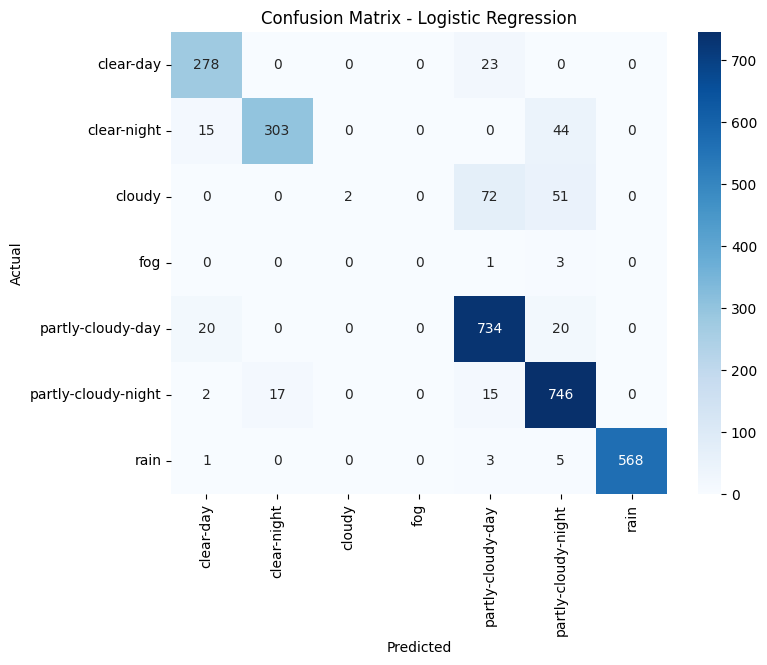

In [25]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [26]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [27]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [28]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9944
clear-night : 0.9952
cloudy   : 0.9260
fog      : 0.7421
partly-cloudy-day : 0.9861
partly-cloudy-night : 0.9860
rain     : 1.0000
Micro-avg : 0.9921


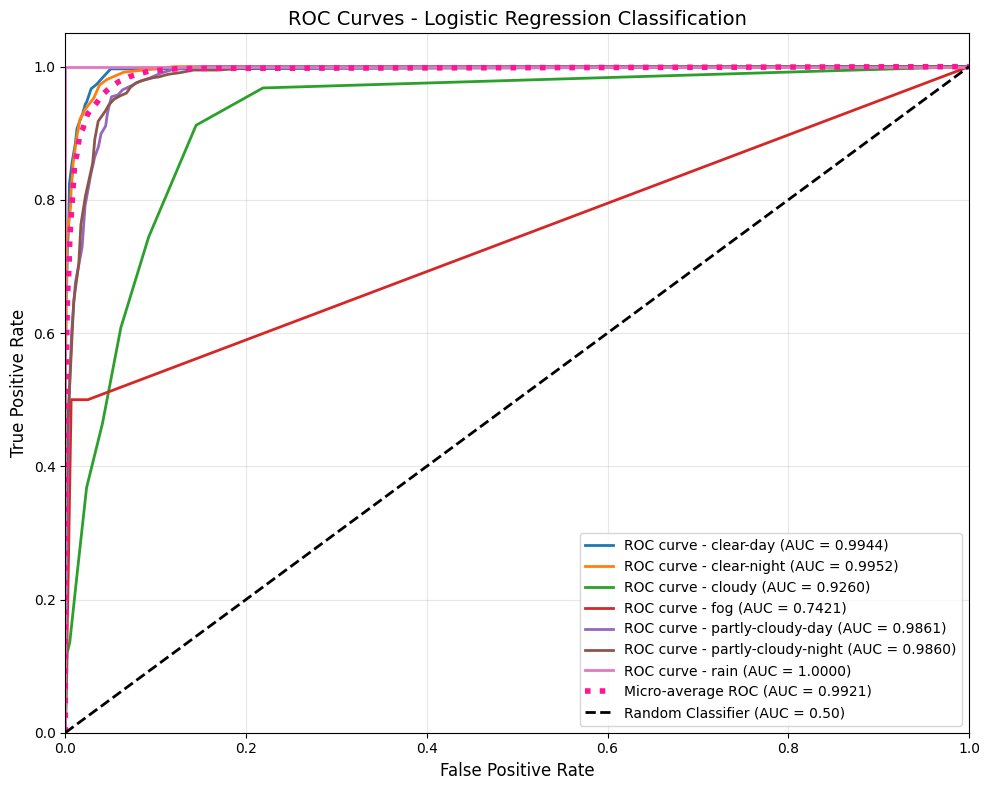

In [29]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9879
One-vs-One (Weighted)  : 0.9537
Micro-average          : 0.9921


In [31]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.900103, F1: 0.881133, AUC (micro-avg): 0.992148
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [32]:
grid_search = RandomizedSearchCV(
    KNeighborsClassifier(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [33]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
CPU times: user 17.3 s, sys: 6.82 s, total: 24.1 s
Wall time: 1h 26min 15s


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [34]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 3, 'metric': 'minkowski', 'leaf_size': 20, 'algorithm': 'auto'}
Best Cross-Validation Score: 0.9084273022083643


In [35]:
y_pred_grid = best_grid_model.predict(X_test)

In [36]:
y_pred_grid

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], dtype=object)

In [37]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [38]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [39]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9254
Precision: 0.9194
Recall:    0.9254
F1-Score:  0.9196


In [40]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.93      0.93      0.93       301
        clear-night       0.96      0.95      0.96       362
             cloudy       0.65      0.31      0.42       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.90      0.94      0.92       774
partly-cloudy-night       0.91      0.95      0.93       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.93      2923
          macro avg       0.76      0.73      0.74      2923
       weighted avg       0.92      0.93      0.92      2923



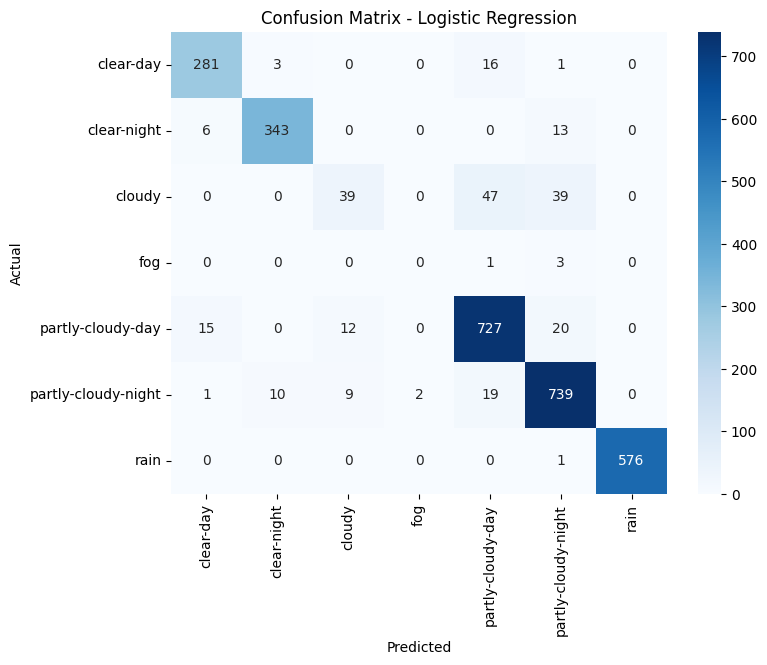

In [41]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [42]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [43]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [44]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9861
clear-night : 0.9873
cloudy   : 0.7657
fog      : 0.4983
partly-cloudy-day : 0.9768
partly-cloudy-night : 0.9774
rain     : 0.9991
Micro-avg : 0.9780


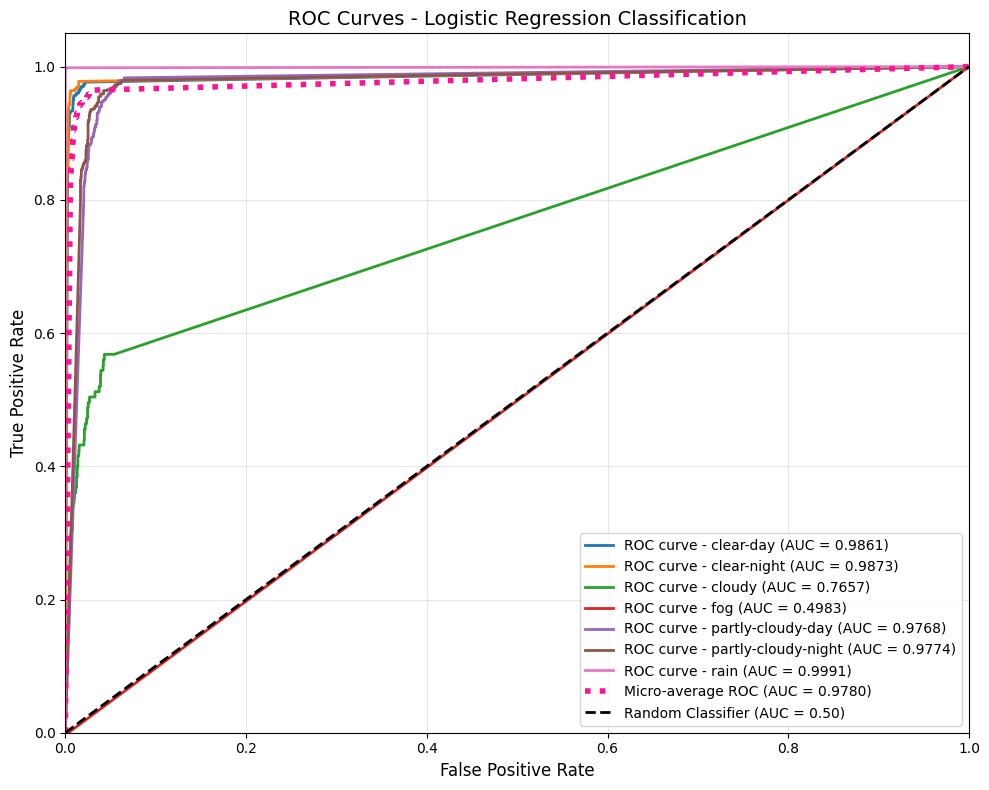

In [45]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [46]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9740
One-vs-One (Weighted)  : 0.9096
Micro-average          : 0.9780


In [47]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.925419, F1: 0.919585, AUC (micro-avg): 0.977986
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [48]:
base_model = KNeighborsClassifier()
base_model

KNeighborsClassifier()

In [49]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [50]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.0s remaining:    1.0s


CPU times: user 160 ms, sys: 543 ms, total: 703 ms
Wall time: 1.4 s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.3s finished


BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [51]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.2s remaining:    7.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.3s finished


In [52]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [53]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9425
Precision: 0.9424
Recall:    0.9425
F1-Score:  0.9327


In [54]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.96      0.96      0.96       301
        clear-night       0.99      0.95      0.97       362
             cloudy       0.94      0.23      0.37       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.91      0.97      0.94       774
partly-cloudy-night       0.91      0.98      0.95       780
               rain       0.99      1.00      1.00       577

           accuracy                           0.94      2923
          macro avg       0.81      0.73      0.74      2923
       weighted avg       0.94      0.94      0.93      2923



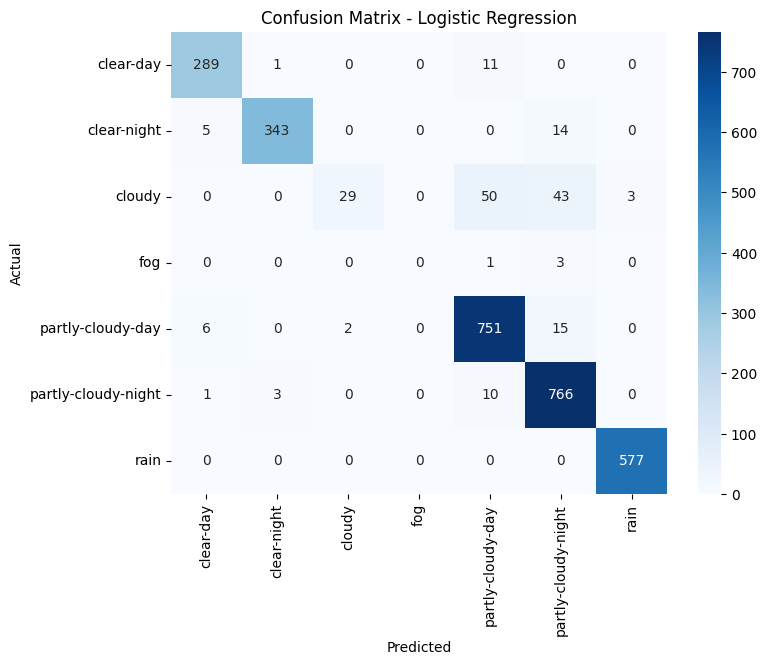

In [55]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [56]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.2s remaining:    7.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.3s finished


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [57]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [58]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9987
clear-night : 0.9992
cloudy   : 0.9752
fog      : 0.9917
partly-cloudy-day : 0.9943
partly-cloudy-night : 0.9952
rain     : 1.0000
Micro-avg : 0.9960


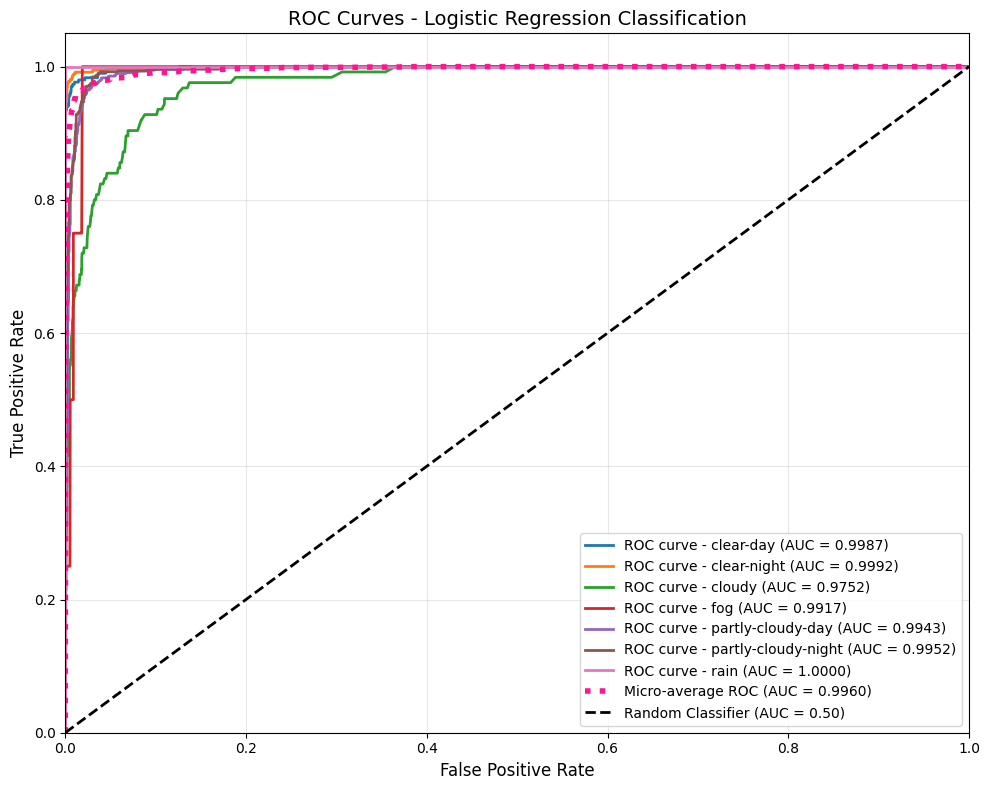

In [59]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [60]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9959
One-vs-One (Weighted)  : 0.9908
Micro-average          : 0.9960


In [61]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.942525, F1: 0.932729, AUC (micro-avg): 0.995960
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


## Standard Scaler

In [62]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [63]:
X_train

array([[ 0.08873237, -0.9946814 , -1.51753864, ..., -0.14489532,
        -0.73058589,  0.85292311],
       [ 0.08873237,  1.04440482,  1.07523376, ...,  0.50907697,
        -0.73058589, -0.4299225 ],
       [ 0.71351944,  1.38425252,  1.21927667, ..., -0.0533392 ,
        -0.73058589, -0.25690934],
       ...,
       [ 0.40112591,  0.59127454, -1.22945281, ...,  1.02116571,
        -0.73058589, -0.4299225 ],
       [ 0.08873237, -0.54155113, -0.07710953, ...,  0.95690582,
         2.19882202,  0.86767617],
       [ 0.40112591, -1.33452911, -0.36519535, ...,  1.29498106,
         0.80247092, -0.4299225 ]])

In [64]:
X_test

array([[ 1.33830651,  1.72410022, -1.51753864, ..., -1.4289557 ,
        -0.73058589, -0.4299225 ],
       [-0.22366116, -0.54155113, -1.22945281, ..., -0.12186412,
        -0.73058589, -0.49027592],
       [ 0.71351944,  0.47799198,  0.49906212, ...,  0.88667489,
         0.86431397,  0.7382516 ],
       ...,
       [ 0.71351944, -1.22124654, -1.22945281, ...,  0.10105513,
        -0.73058589, -0.4299225 ],
       [ 1.65070004, -0.314986  ,  0.35501921, ..., -0.69536939,
         1.54784248, -0.4299225 ],
       [ 0.71351944, -0.88139884, -0.07710953, ...,  1.32256164,
        -0.34325307, -0.4299225 ]])

### Default Parameters

In [65]:
training_model = KNeighborsClassifier()
training_model

KNeighborsClassifier()

In [66]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 13.5 ms, sys: 147 µs, total: 13.6 ms
Wall time: 12.6 ms


KNeighborsClassifier()

In [67]:
y_pred = training_model.predict(X_test)
y_pred

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], dtype=object)

In [68]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [69]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [70]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.8953
Precision: 0.8846
Recall:    0.8953
F1-Score:  0.8867


In [71]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.87      0.89      0.88       301
        clear-night       0.94      0.87      0.91       362
             cloudy       0.46      0.18      0.26       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.87      0.92      0.89       774
partly-cloudy-night       0.87      0.93      0.90       780
               rain       1.00      0.99      0.99       577

           accuracy                           0.90      2923
          macro avg       0.72      0.68      0.69      2923
       weighted avg       0.88      0.90      0.89      2923



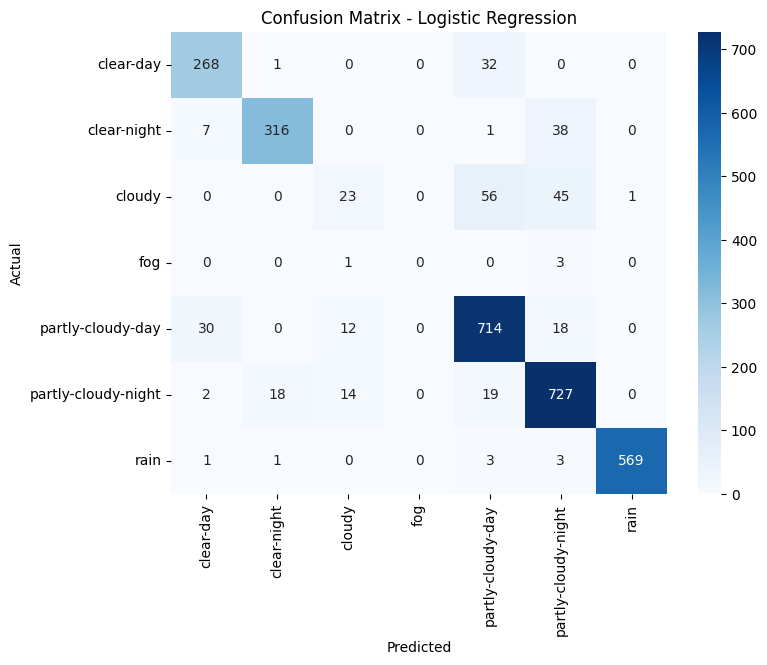

In [72]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [73]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [74]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [75]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9858
clear-night : 0.9847
cloudy   : 0.8044
fog      : 0.7456
partly-cloudy-day : 0.9774
partly-cloudy-night : 0.9783
rain     : 0.9982
Micro-avg : 0.9808


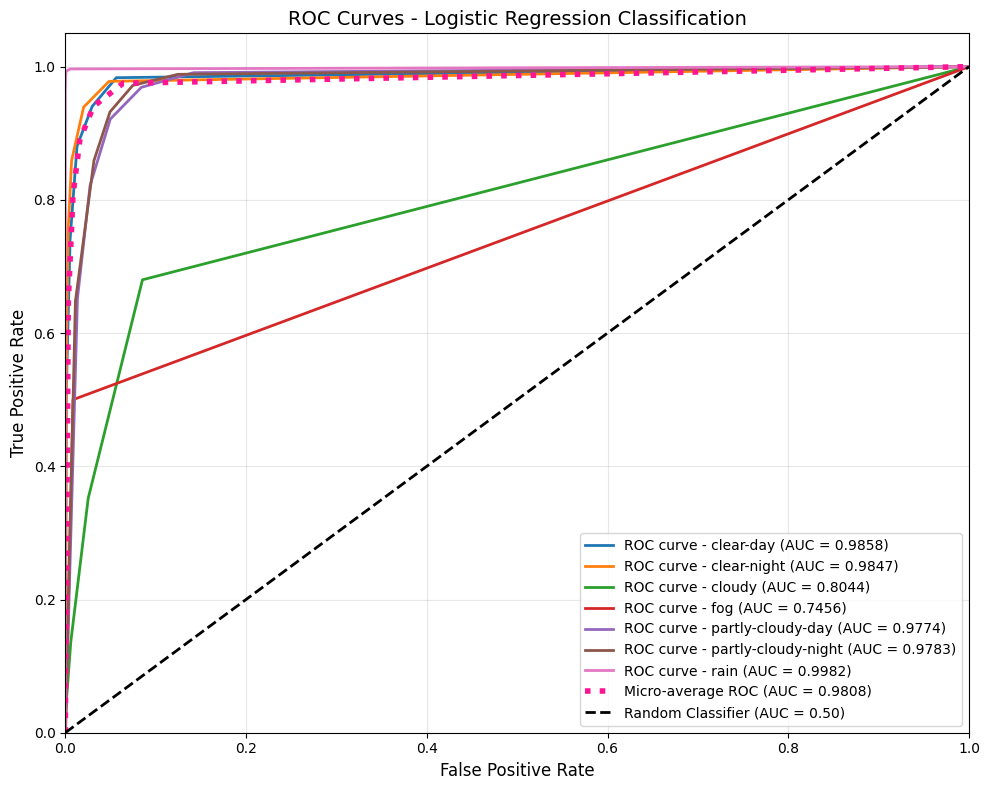

In [76]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [77]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9758
One-vs-One (Weighted)  : 0.9377
Micro-average          : 0.9808


In [78]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.895313, F1: 0.886734, AUC (micro-avg): 0.980821
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [79]:
grid_search = RandomizedSearchCV(
    KNeighborsClassifier(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [80]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
CPU times: user 19.7 s, sys: 8.67 s, total: 28.4 s
Wall time: 1h 44min 47s


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [81]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 7, 'metric': 'manhattan', 'leaf_size': 20, 'algorithm': 'ball_tree'}
Best Cross-Validation Score: 0.8800670163794265


In [82]:
y_pred_grid = best_grid_model.predict(X_test)

In [83]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [84]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.8974
Precision: 0.8937
Recall:    0.8974
F1-Score:  0.8893


In [85]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.86      0.87      0.87       301
        clear-night       0.92      0.91      0.92       362
             cloudy       0.72      0.22      0.34       125
                fog       0.50      0.25      0.33         4
  partly-cloudy-day       0.86      0.93      0.89       774
partly-cloudy-night       0.88      0.94      0.91       780
               rain       0.99      0.95      0.97       577

           accuracy                           0.90      2923
          macro avg       0.82      0.73      0.75      2923
       weighted avg       0.89      0.90      0.89      2923



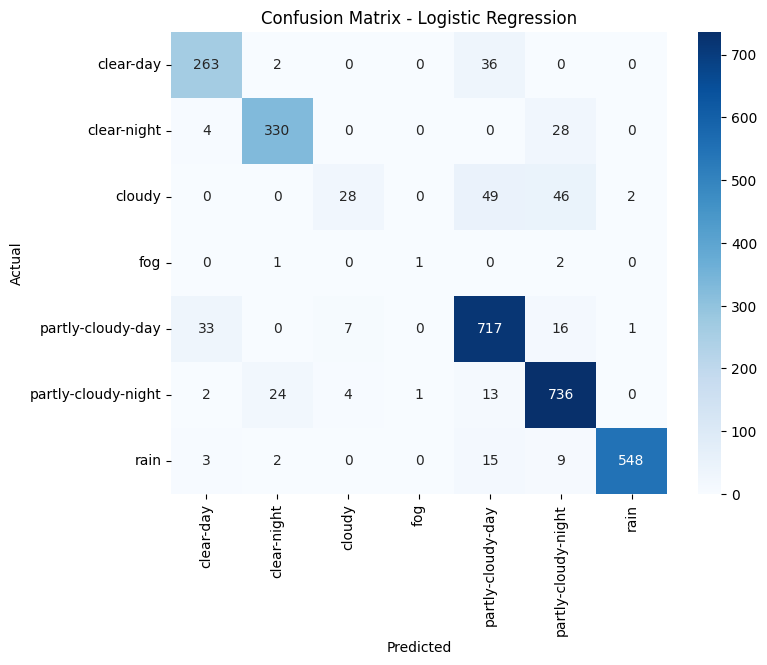

In [86]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [87]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [88]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [89]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9887
clear-night : 0.9895
cloudy   : 0.8656
fog      : 0.7473
partly-cloudy-day : 0.9816
partly-cloudy-night : 0.9831
rain     : 0.9979
Micro-avg : 0.9856


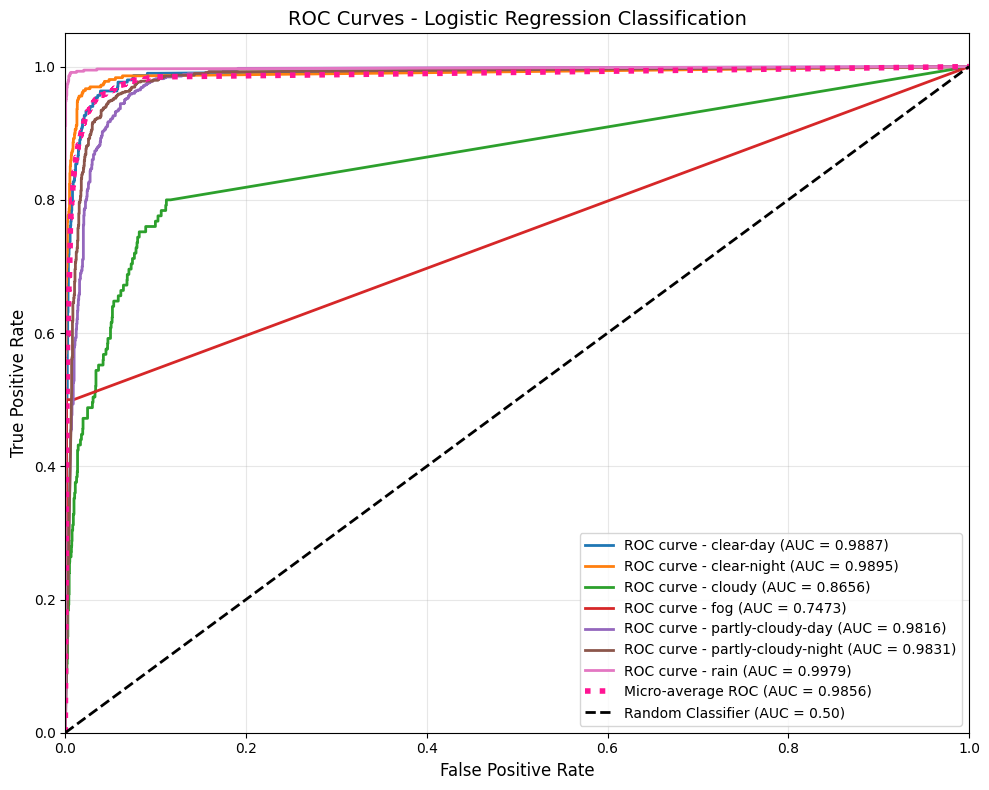

In [90]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [91]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9816
One-vs-One (Weighted)  : 0.9486
Micro-average          : 0.9856


In [92]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.897366, F1: 0.889260, AUC (micro-avg): 0.985563
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [93]:
base_model = KNeighborsClassifier()
base_model

KNeighborsClassifier()

In [94]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [95]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.9s remaining:    0.9s


CPU times: user 278 ms, sys: 440 ms, total: 718 ms
Wall time: 1.32 s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.2s finished


BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [96]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.2s remaining:    7.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.4s finished


In [97]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [98]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9326
Precision: 0.9307
Recall:    0.9326
F1-Score:  0.9205


In [99]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.95      0.94      0.95       301
        clear-night       0.98      0.94      0.96       362
             cloudy       0.87      0.16      0.27       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.90      0.97      0.93       774
partly-cloudy-night       0.90      0.97      0.94       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.93      2923
          macro avg       0.80      0.71      0.72      2923
       weighted avg       0.93      0.93      0.92      2923



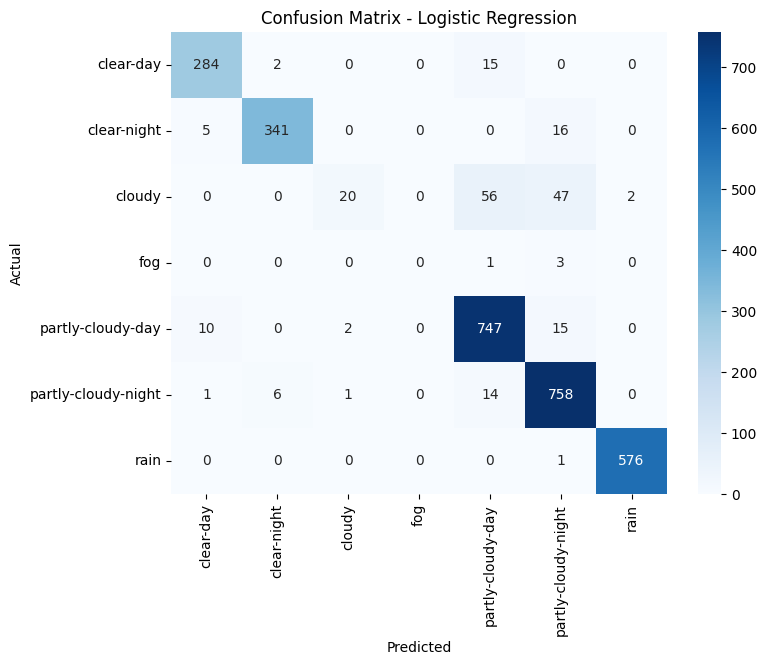

In [100]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [101]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.2s remaining:    7.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.3s finished


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [102]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [103]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9976
clear-night : 0.9987
cloudy   : 0.9611
fog      : 0.9918
partly-cloudy-day : 0.9918
partly-cloudy-night : 0.9929
rain     : 1.0000
Micro-avg : 0.9946


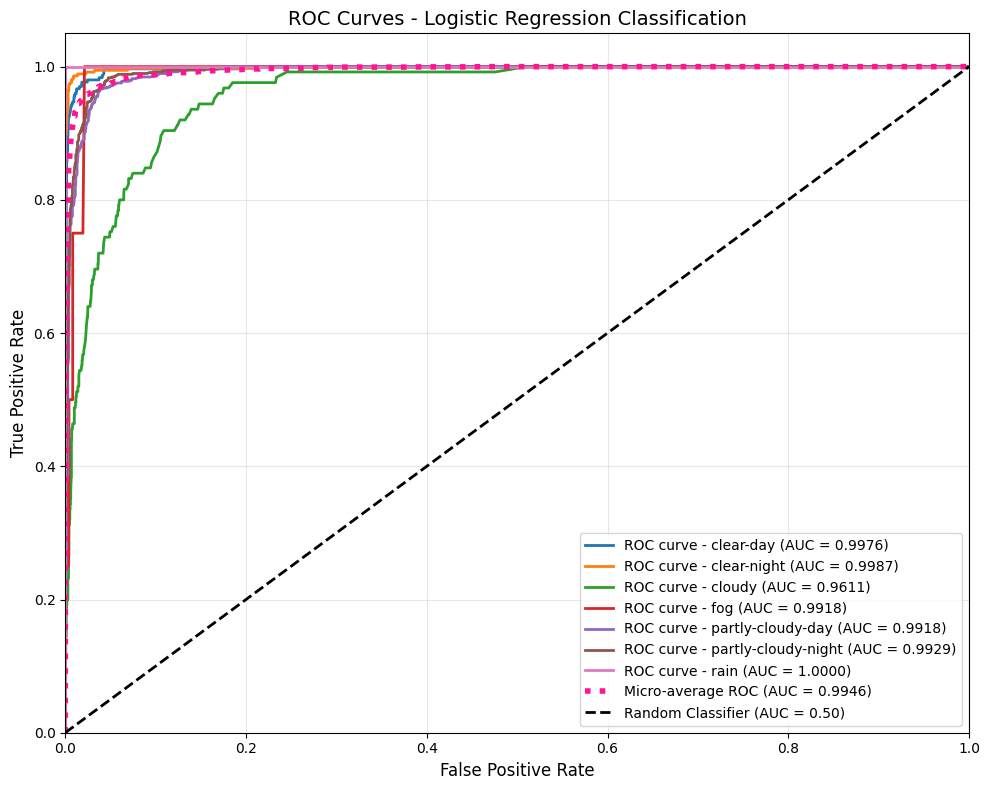

In [104]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [105]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9939
One-vs-One (Weighted)  : 0.9872
Micro-average          : 0.9946


In [106]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.932603, F1: 0.920456, AUC (micro-avg): 0.994633
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


## Robust Scaler

In [107]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [108]:
X_train

array([[ 0.00000000e+00, -6.00000000e-01, -9.16666667e-01, ...,
        -5.05562827e-02,  0.00000000e+00,  9.07710558e+00],
       [ 0.00000000e+00,  6.00000000e-01,  5.83333333e-01, ...,
         3.25752618e-01,  0.00000000e+00,  0.00000000e+00],
       [ 4.00000000e-01,  8.00000000e-01,  6.66666667e-01, ...,
         2.12696335e-03,  0.00000000e+00,  1.22419929e+00],
       ...,
       [ 2.00000000e-01,  3.33333333e-01, -7.50000000e-01, ...,
         6.20418848e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -3.33333333e-01, -8.33333333e-02, ...,
         5.83442408e-01,  1.94805195e+00,  9.18149466e+00],
       [ 2.00000000e-01, -8.00000000e-01, -2.50000000e-01, ...,
         7.77977749e-01,  1.01948052e+00,  0.00000000e+00]])

In [109]:
X_test

array([[ 0.8       ,  1.        , -0.91666667, ..., -0.78943063,
         0.        ,  0.        ],
       [-0.2       , -0.33333333, -0.75      , ..., -0.03730366,
         0.        , -0.42704626],
       [ 0.4       ,  0.26666667,  0.25      , ...,  0.5430301 ,
         1.06060606,  8.26571767],
       ...,
       [ 0.4       , -0.73333333, -0.75      , ...,  0.09096859,
         0.        ,  0.        ],
       [ 1.        , -0.2       ,  0.16666667, ..., -0.36731021,
         1.51515152,  0.        ],
       [ 0.4       , -0.53333333, -0.08333333, ...,  0.79384817,
         0.25757576,  0.        ]])

### Default Parameters

In [110]:
training_model = KNeighborsClassifier()
training_model

KNeighborsClassifier()

In [111]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 13.8 ms, sys: 0 ns, total: 13.8 ms
Wall time: 12.8 ms


KNeighborsClassifier()

In [112]:
y_pred = training_model.predict(X_test)
y_pred

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], dtype=object)

In [113]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [114]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [115]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.8758
Precision: 0.8647
Recall:    0.8758
F1-Score:  0.8682


In [116]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.84      0.86      0.85       301
        clear-night       0.91      0.84      0.88       362
             cloudy       0.37      0.18      0.24       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.85      0.90      0.87       774
partly-cloudy-night       0.86      0.90      0.88       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.88      2923
          macro avg       0.69      0.67      0.67      2923
       weighted avg       0.86      0.88      0.87      2923



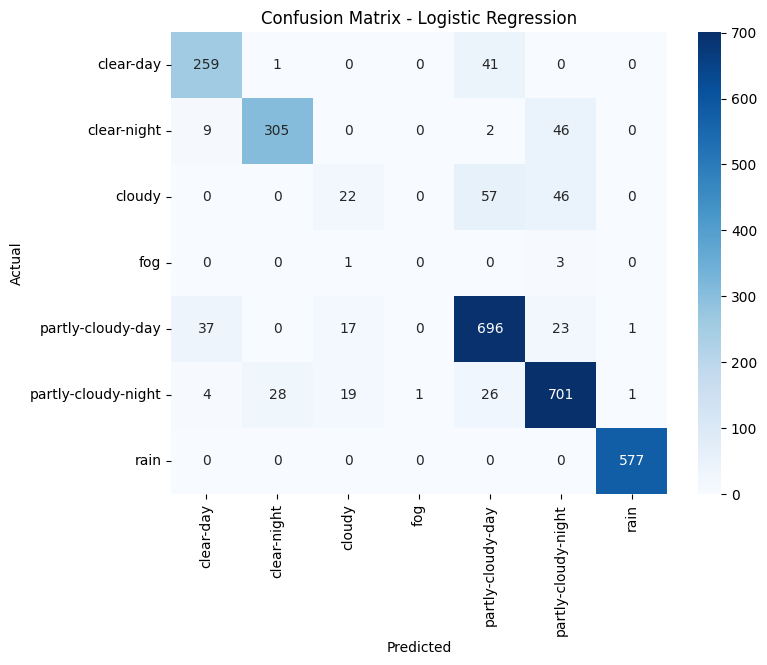

In [117]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [118]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [119]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [120]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9793
clear-night : 0.9819
cloudy   : 0.8034
fog      : 0.7461
partly-cloudy-day : 0.9715
partly-cloudy-night : 0.9698
rain     : 1.0000
Micro-avg : 0.9780


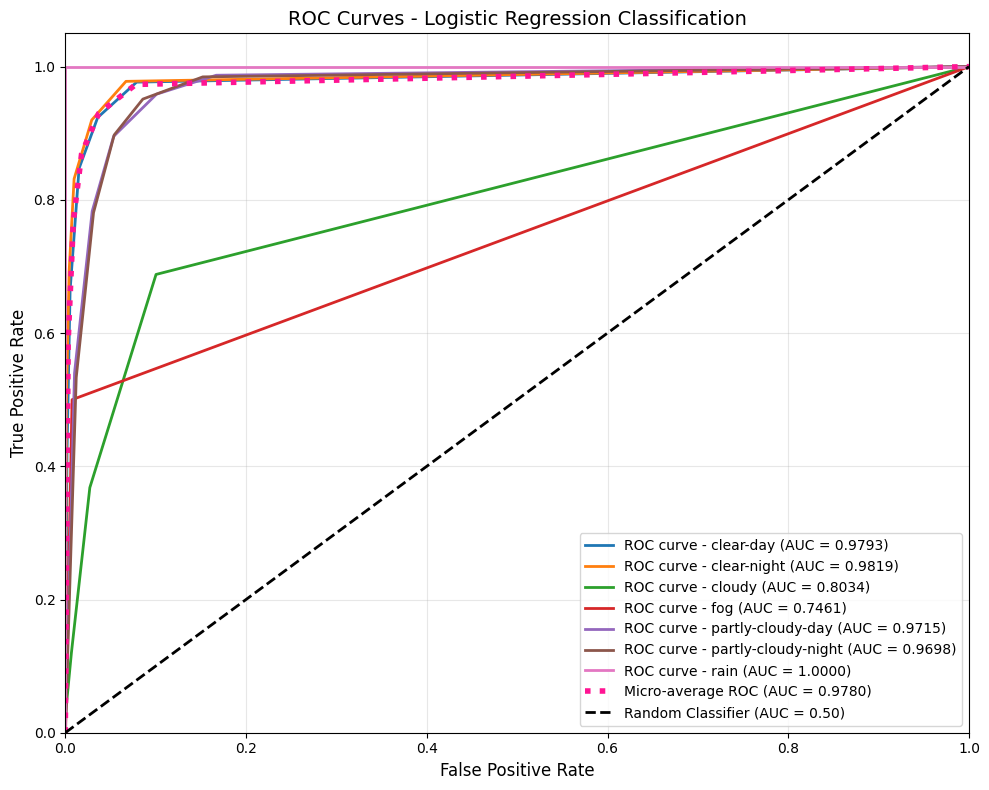

In [121]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [122]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9713
One-vs-One (Weighted)  : 0.9329
Micro-average          : 0.9780


In [123]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.875813, F1: 0.868196, AUC (micro-avg): 0.978048
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [124]:
grid_search = RandomizedSearchCV(
    KNeighborsClassifier(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [125]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
CPU times: user 14.6 s, sys: 6.15 s, total: 20.8 s
Wall time: 1h 17min 5s


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [126]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 9, 'metric': 'manhattan', 'leaf_size': 50, 'algorithm': 'kd_tree'}
Best Cross-Validation Score: 0.876921168370791


In [127]:
y_pred_grid = best_grid_model.predict(X_test)

In [128]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [129]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9001
Precision: 0.8958
Recall:    0.9001
F1-Score:  0.8878


In [130]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.85      0.86      0.85       301
        clear-night       0.93      0.90      0.92       362
             cloudy       0.77      0.14      0.23       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.86      0.92      0.89       774
partly-cloudy-night       0.88      0.95      0.92       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.90      2923
          macro avg       0.76      0.68      0.69      2923
       weighted avg       0.90      0.90      0.89      2923



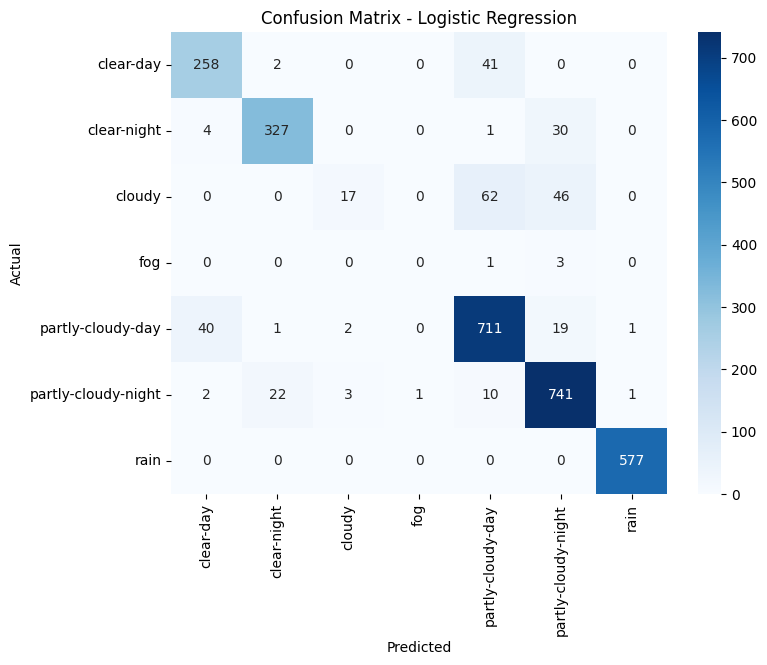

In [131]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [132]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [133]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [134]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9899
clear-night : 0.9939
cloudy   : 0.8729
fog      : 0.7469
partly-cloudy-day : 0.9802
partly-cloudy-night : 0.9820
rain     : 1.0000
Micro-avg : 0.9878


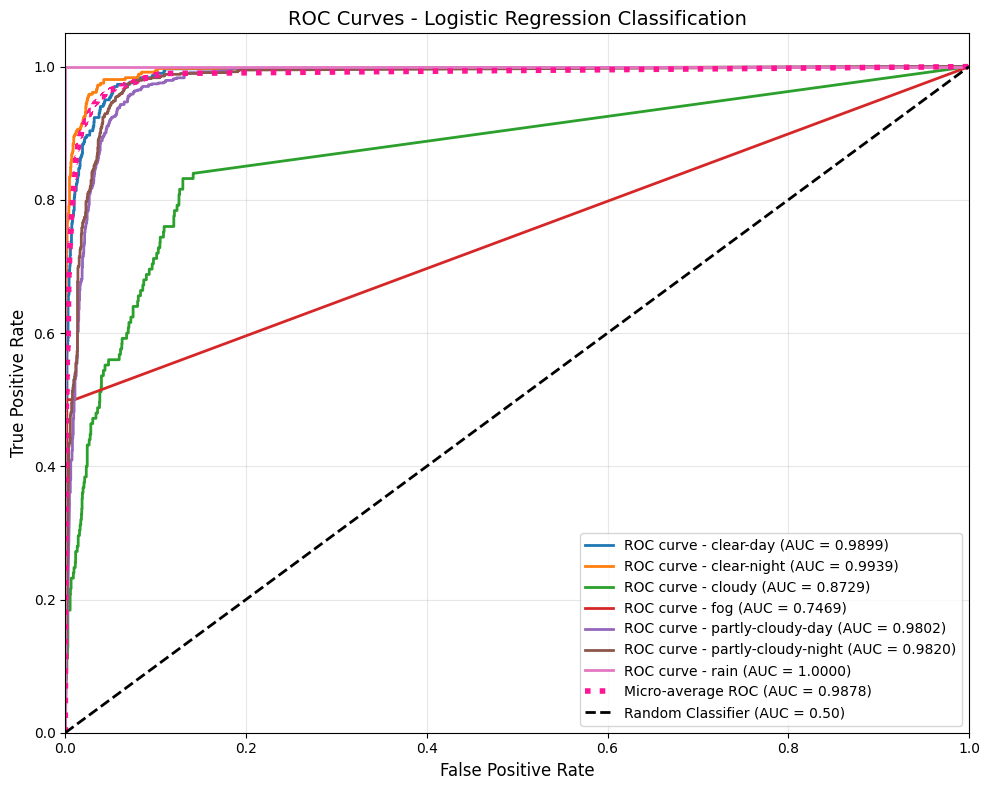

In [135]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [136]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9824
One-vs-One (Weighted)  : 0.9490
Micro-average          : 0.9878


In [137]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.900103, F1: 0.887822, AUC (micro-avg): 0.987808
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [138]:
base_model = KNeighborsClassifier()
base_model

KNeighborsClassifier()

In [139]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [140]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s


CPU times: user 201 ms, sys: 473 ms, total: 674 ms
Wall time: 1.23 s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.1s finished


BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [141]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.2s remaining:    7.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.3s finished


In [142]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [143]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9213
Precision: 0.9178
Recall:    0.9213
F1-Score:  0.9070


In [144]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.94      0.92      0.93       301
        clear-night       0.97      0.92      0.95       362
             cloudy       0.81      0.10      0.18       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.88      0.96      0.92       774
partly-cloudy-night       0.89      0.96      0.93       780
               rain       0.99      1.00      1.00       577

           accuracy                           0.92      2923
          macro avg       0.78      0.70      0.70      2923
       weighted avg       0.92      0.92      0.91      2923



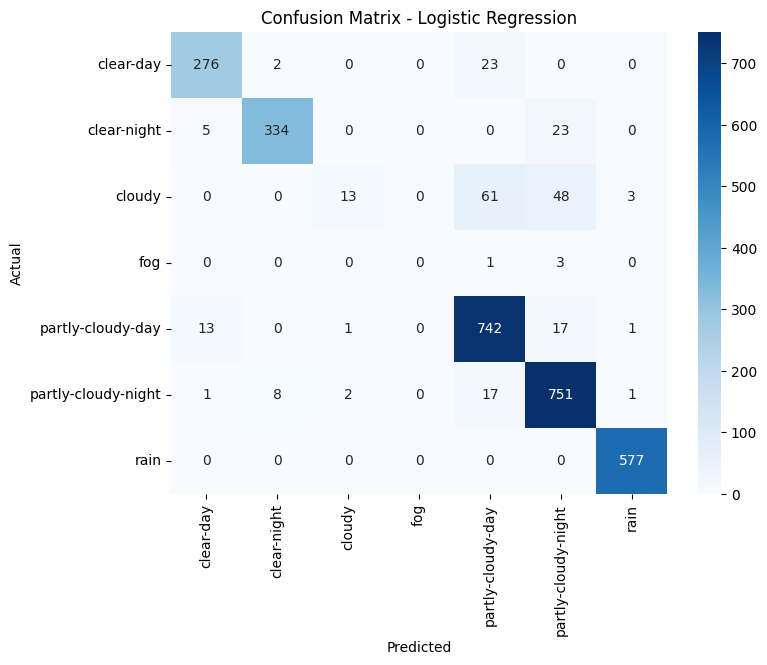

In [145]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [146]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.7s remaining:    7.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.8s finished


In [147]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [148]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9968
clear-night : 0.9985
cloudy   : 0.9471
fog      : 0.9922
partly-cloudy-day : 0.9899
partly-cloudy-night : 0.9895
rain     : 1.0000
Micro-avg : 0.9940


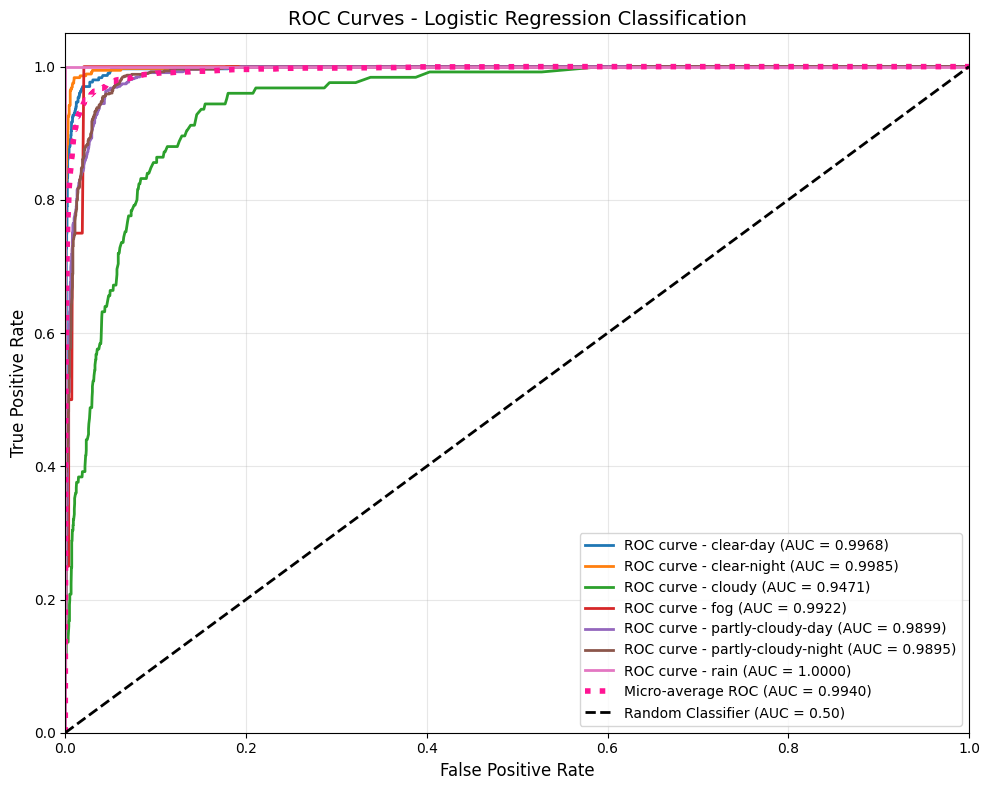

In [149]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [150]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9917
One-vs-One (Weighted)  : 0.9833
Micro-average          : 0.9940


In [151]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.921314, F1: 0.906961, AUC (micro-avg): 0.993999
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


# Selected Features

In [152]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning        14616 non-null  int64         
 12  DayS

## Run Again

In [153]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_train = weather_data_train['Icon']

In [154]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_test = weather_data_test['Icon']

In [155]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [156]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2923
y_test:  2923


### MinMax Scaler

In [157]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [158]:
X_train

array([[0.45454545, 0.04347826, 0.        , ..., 0.4839    , 0.        ,
        0.27580747],
       [0.45454545, 0.82608696, 0.        , ..., 0.7139    , 0.        ,
        0.07388643],
       [0.63636364, 0.86956522, 0.        , ..., 0.5161    , 0.        ,
        0.10111885],
       ...,
       [0.54545455, 0.13043478, 0.        , ..., 0.894     , 0.        ,
        0.07388643],
       [0.45454545, 0.47826087, 0.        , ..., 0.8714    , 0.9       ,
        0.27812962],
       [0.54545455, 0.39130435, 0.        , ..., 0.9903    , 0.471     ,
        0.07388643]])

In [159]:
X_test

array([[0.81818182, 0.04347826, 0.        , ..., 0.0323    , 0.        ,
        0.07388643],
       [0.36363636, 0.13043478, 0.        , ..., 0.492     , 0.        ,
        0.06438674],
       [0.63636364, 0.65217391, 1.        , ..., 0.8467    , 0.49      ,
        0.25775807],
       ...,
       [0.63636364, 0.13043478, 0.        , ..., 0.5704    , 0.        ,
        0.07388643],
       [0.90909091, 0.60869565, 1.        , ..., 0.2903    , 0.7       ,
        0.07388643],
       [0.63636364, 0.47826087, 0.        , ..., 1.        , 0.119     ,
        0.07388643]])

#### Default Parameters

In [160]:
training_model = KNeighborsClassifier()
training_model

KNeighborsClassifier()

In [161]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 13.7 ms, sys: 0 ns, total: 13.7 ms
Wall time: 12.6 ms


KNeighborsClassifier()

In [162]:
y_pred = training_model.predict(X_test)
y_pred

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], dtype=object)

In [163]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [164]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [165]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9442
Precision: 0.9392
Recall:    0.9442
F1-Score:  0.9382


In [166]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.97      0.95      0.96       301
        clear-night       0.98      0.96      0.97       362
             cloudy       0.72      0.33      0.45       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.91      0.97      0.94       774
partly-cloudy-night       0.93      0.98      0.95       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.94      2923
          macro avg       0.79      0.74      0.75      2923
       weighted avg       0.94      0.94      0.94      2923



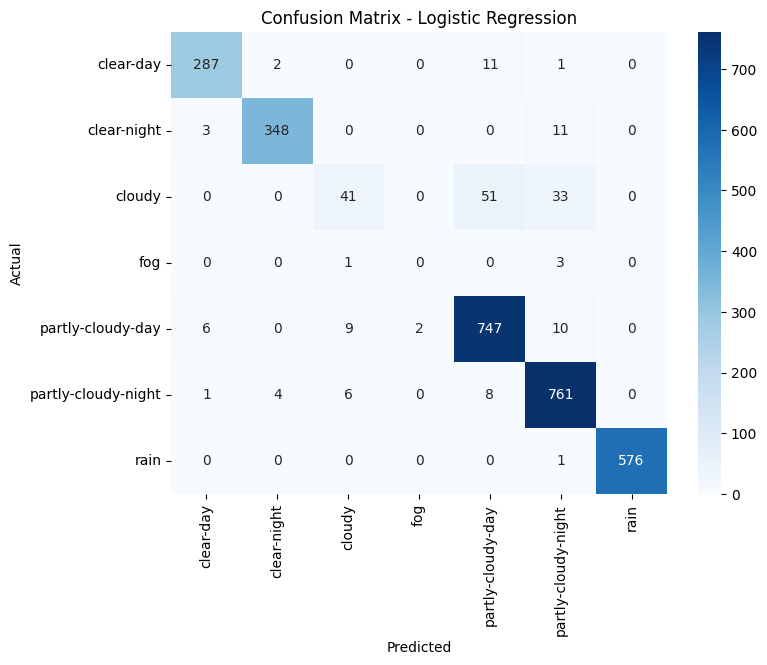

In [167]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [168]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [169]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [170]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9927
clear-night : 0.9926
cloudy   : 0.9107
fog      : 0.6236
partly-cloudy-day : 0.9908
partly-cloudy-night : 0.9929
rain     : 0.9991
Micro-avg : 0.9917


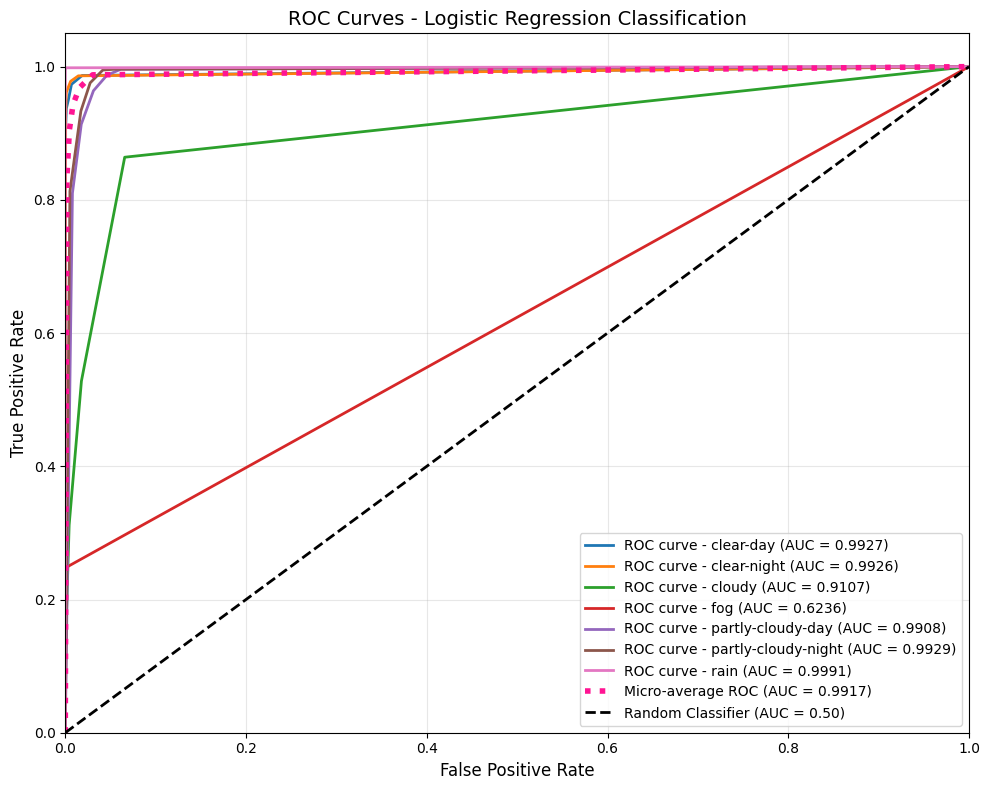

In [171]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [172]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9895
One-vs-One (Weighted)  : 0.9499
Micro-average          : 0.9917


In [173]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.900103 → 0.944235
   F1-Score: 0.881133 → 0.938218
   AUC (micro-avg): 0.992148 → 0.991715
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [174]:
grid_search = RandomizedSearchCV(
    KNeighborsClassifier(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [175]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
CPU times: user 13.6 s, sys: 5.43 s, total: 19 s
Wall time: 1h 8min 6s


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [176]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 5, 'metric': 'manhattan', 'leaf_size': 40, 'algorithm': 'ball_tree'}
Best Cross-Validation Score: 0.9394142903400915


In [177]:
y_pred_grid = best_grid_model.predict(X_test)

In [178]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [179]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9490
Precision: 0.9464
Recall:    0.9490
F1-Score:  0.9440


In [180]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.96      0.96      0.96       301
        clear-night       0.98      0.96      0.97       362
             cloudy       0.80      0.38      0.52       125
                fog       1.00      0.25      0.40         4
  partly-cloudy-day       0.92      0.96      0.94       774
partly-cloudy-night       0.93      0.98      0.96       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.95      2923
          macro avg       0.94      0.79      0.82      2923
       weighted avg       0.95      0.95      0.94      2923



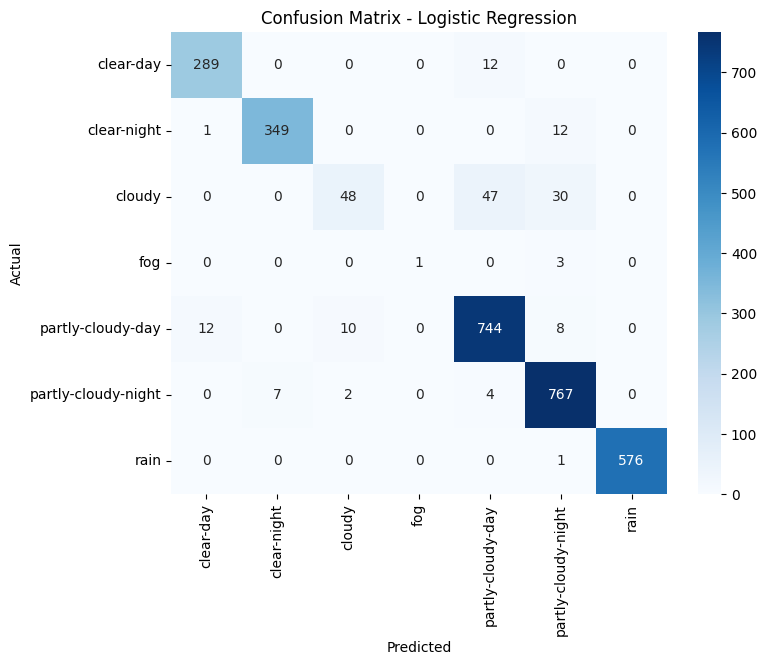

In [181]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [182]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [183]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [184]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9959
clear-night : 0.9981
cloudy   : 0.9219
fog      : 0.6235
partly-cloudy-day : 0.9927
partly-cloudy-night : 0.9949
rain     : 0.9991
Micro-avg : 0.9937


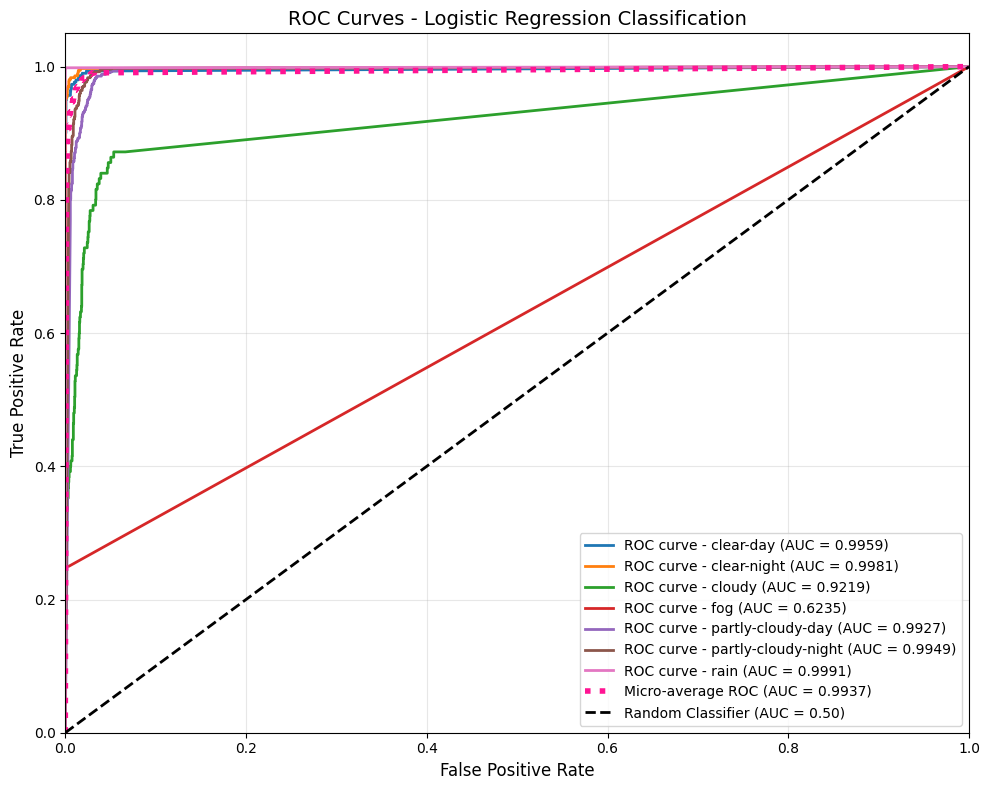

In [185]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [186]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9920
One-vs-One (Weighted)  : 0.9536
Micro-average          : 0.9937


In [187]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.925419 → 0.949025
   F1-Score: 0.919585 → 0.943972
   AUC (micro-avg): 0.977986 → 0.993655
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [188]:
base_model = KNeighborsClassifier()
base_model

KNeighborsClassifier()

In [189]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [190]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s


CPU times: user 176 ms, sys: 404 ms, total: 580 ms
Wall time: 1.1 s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.0s finished


BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [191]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.9s remaining:    6.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.0s finished


In [192]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [193]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9531
Precision: 0.9531
Recall:    0.9531
F1-Score:  0.9464


In [194]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.98      0.96      0.97       301
        clear-night       0.99      0.95      0.97       362
             cloudy       0.96      0.34      0.51       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.92      0.98      0.95       774
partly-cloudy-night       0.93      0.99      0.96       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.95      2923
          macro avg       0.82      0.75      0.76      2923
       weighted avg       0.95      0.95      0.95      2923



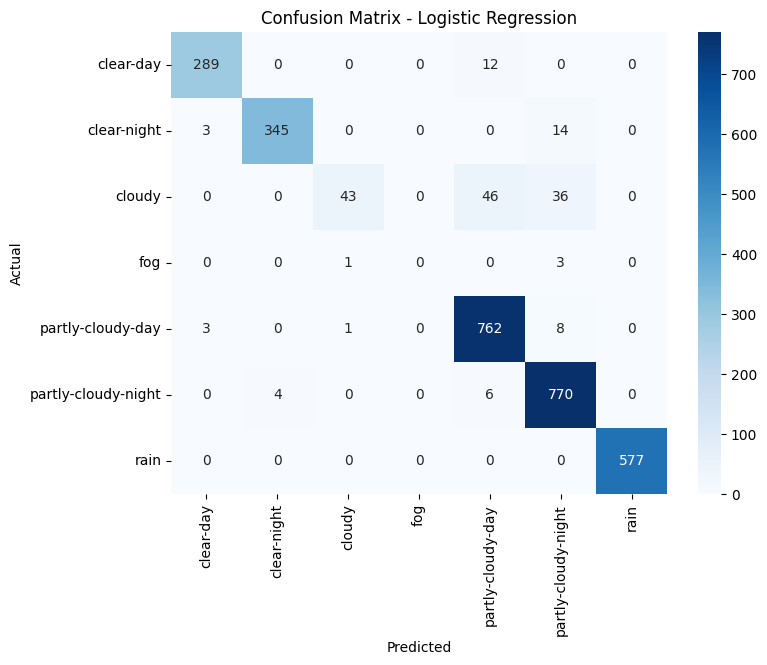

In [195]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [196]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.9s remaining:    6.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.0s finished


In [197]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [198]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9976
clear-night : 0.9987
cloudy   : 0.9832
fog      : 0.9957
partly-cloudy-day : 0.9954
partly-cloudy-night : 0.9957
rain     : 1.0000
Micro-avg : 0.9962


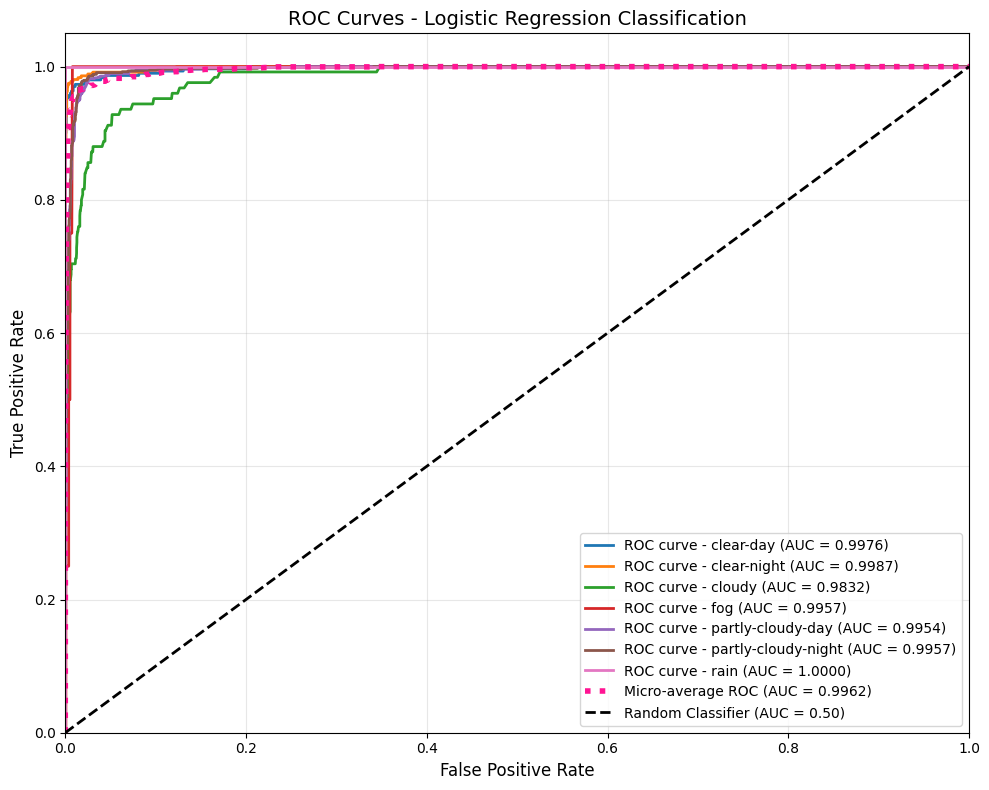

In [199]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [200]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9965
One-vs-One (Weighted)  : 0.9925
Micro-average          : 0.9962


In [201]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.942525 → 0.953130
   F1-Score: 0.932729 → 0.946395
   AUC (micro-avg): 0.995960 → 0.996225
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


### Standard Scaler

In [202]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [203]:
X_train

array([[ 0.08873237, -1.51753864, -0.3888967 , ..., -0.14489532,
        -0.73058589,  0.85292311],
       [ 0.08873237,  1.07523376, -0.3888967 , ...,  0.50907697,
        -0.73058589, -0.4299225 ],
       [ 0.71351944,  1.21927667, -0.3888967 , ..., -0.0533392 ,
        -0.73058589, -0.25690934],
       ...,
       [ 0.40112591, -1.22945281, -0.3888967 , ...,  1.02116571,
        -0.73058589, -0.4299225 ],
       [ 0.08873237, -0.07710953, -0.3888967 , ...,  0.95690582,
         2.19882202,  0.86767617],
       [ 0.40112591, -0.36519535, -0.3888967 , ...,  1.29498106,
         0.80247092, -0.4299225 ]])

In [204]:
X_test

array([[ 1.33830651, -1.51753864, -0.3888967 , ..., -1.4289557 ,
        -0.73058589, -0.4299225 ],
       [-0.22366116, -1.22945281, -0.3888967 , ..., -0.12186412,
        -0.73058589, -0.49027592],
       [ 0.71351944,  0.49906212,  2.5713769 , ...,  0.88667489,
         0.86431397,  0.7382516 ],
       ...,
       [ 0.71351944, -1.22945281, -0.3888967 , ...,  0.10105513,
        -0.73058589, -0.4299225 ],
       [ 1.65070004,  0.35501921,  2.5713769 , ..., -0.69536939,
         1.54784248, -0.4299225 ],
       [ 0.71351944, -0.07710953, -0.3888967 , ...,  1.32256164,
        -0.34325307, -0.4299225 ]])

#### Default Parameters

In [205]:
training_model = KNeighborsClassifier()
training_model

KNeighborsClassifier()

In [206]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 12.7 ms, sys: 38 µs, total: 12.7 ms
Wall time: 12.2 ms


KNeighborsClassifier()

In [207]:
y_pred = training_model.predict(X_test)
y_pred

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], dtype=object)

In [208]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [209]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [210]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9264
Precision: 0.9195
Recall:    0.9264
F1-Score:  0.9196


In [211]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.93      0.94      0.93       301
        clear-night       0.97      0.93      0.95       362
             cloudy       0.61      0.26      0.37       125
                fog       0.50      0.25      0.33         4
  partly-cloudy-day       0.89      0.95      0.92       774
partly-cloudy-night       0.91      0.96      0.93       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.93      2923
          macro avg       0.83      0.76      0.78      2923
       weighted avg       0.92      0.93      0.92      2923



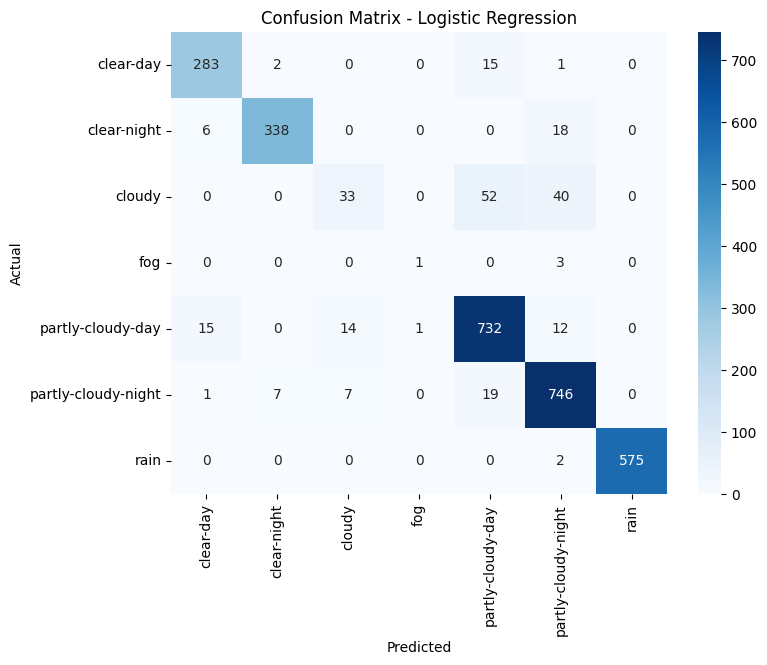

In [212]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [213]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [214]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [215]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9918
clear-night : 0.9922
cloudy   : 0.8692
fog      : 0.7481
partly-cloudy-day : 0.9868
partly-cloudy-night : 0.9877
rain     : 0.9991
Micro-avg : 0.9887


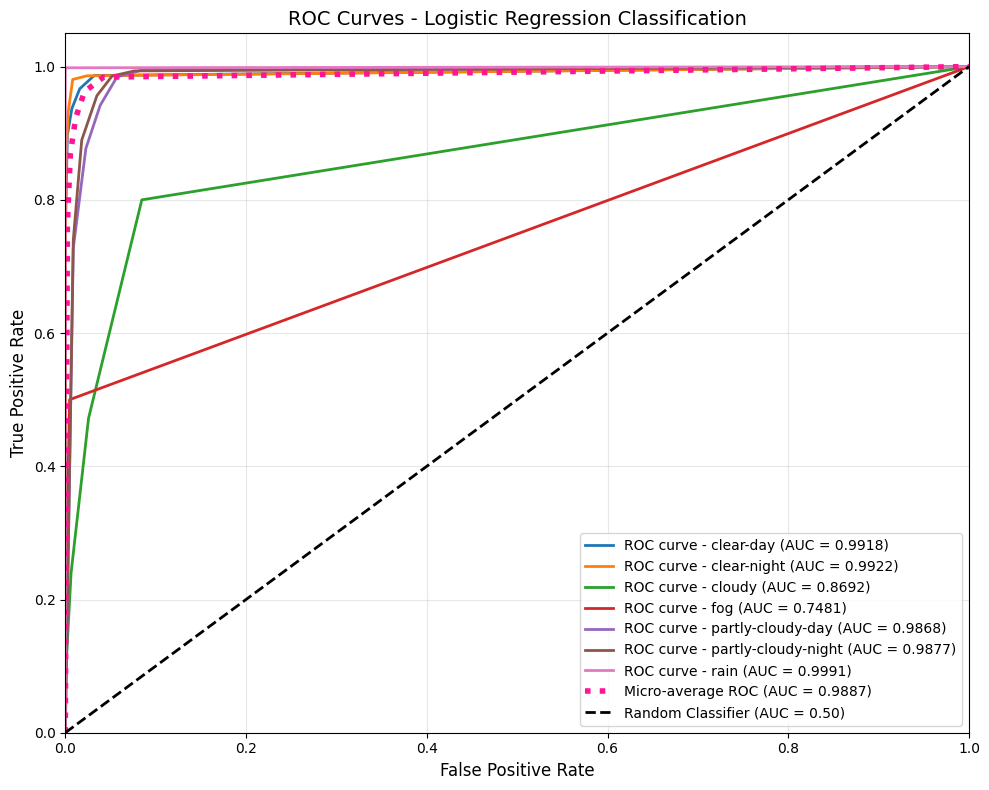

In [216]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [217]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9853
One-vs-One (Weighted)  : 0.9529
Micro-average          : 0.9887


In [218]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.895313 → 0.926445
   F1-Score: 0.886734 → 0.919574
   AUC (micro-avg): 0.980821 → 0.988707
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [219]:
grid_search = RandomizedSearchCV(
    KNeighborsClassifier(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [220]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
CPU times: user 15.7 s, sys: 6.61 s, total: 22.3 s
Wall time: 1h 20min 48s


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [221]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 3, 'metric': 'minkowski', 'leaf_size': 20, 'algorithm': 'auto'}
Best Cross-Validation Score: 0.9196858854456768


In [222]:
y_pred_grid = best_grid_model.predict(X_test)

In [223]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [224]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9302
Precision: 0.9247
Recall:    0.9302
F1-Score:  0.9259


In [225]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.95      0.95      0.95       301
        clear-night       0.97      0.94      0.96       362
             cloudy       0.59      0.35      0.44       125
                fog       0.50      0.25      0.33         4
  partly-cloudy-day       0.90      0.94      0.92       774
partly-cloudy-night       0.91      0.95      0.93       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.93      2923
          macro avg       0.83      0.77      0.79      2923
       weighted avg       0.92      0.93      0.93      2923



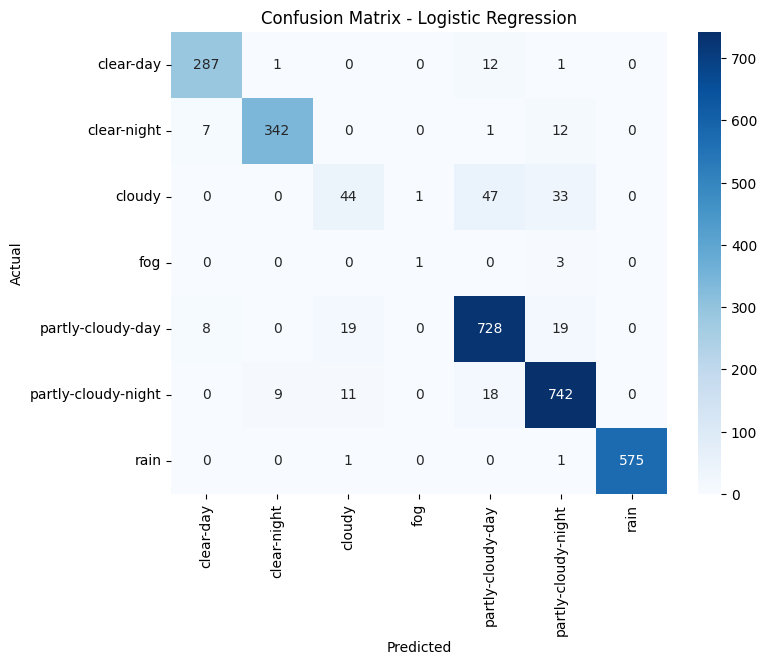

In [226]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [227]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [228]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [229]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9888
clear-night : 0.9894
cloudy   : 0.8259
fog      : 0.6241
partly-cloudy-day : 0.9825
partly-cloudy-night : 0.9861
rain     : 0.9991
Micro-avg : 0.9842


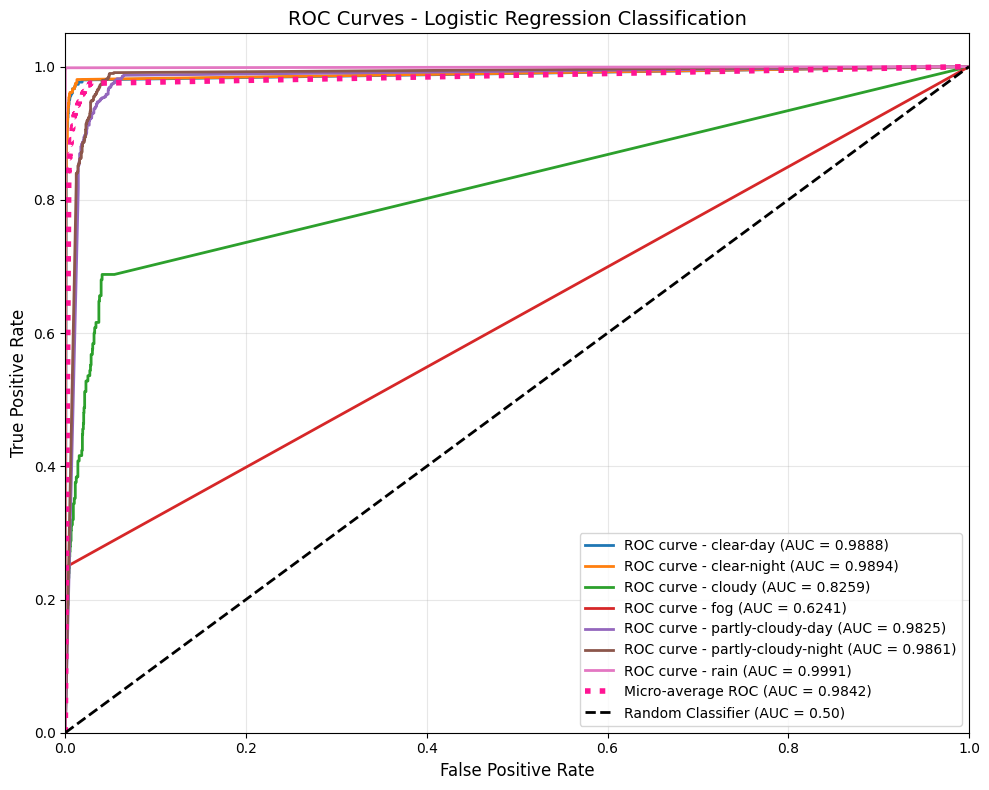

In [230]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [231]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9811
One-vs-One (Weighted)  : 0.9364
Micro-average          : 0.9842


In [232]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.897366 → 0.930209
   F1-Score: 0.889260 → 0.925913
   AUC (micro-avg): 0.985563 → 0.984183
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [233]:
base_model = KNeighborsClassifier()
base_model

KNeighborsClassifier()

In [234]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [235]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s


CPU times: user 149 ms, sys: 464 ms, total: 612 ms
Wall time: 1.14 s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.0s finished


BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [236]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.9s remaining:    6.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.0s finished


In [237]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [238]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9412
Precision: 0.9414
Recall:    0.9412
F1-Score:  0.9317


In [239]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.96      0.94      0.95       301
        clear-night       0.99      0.94      0.96       362
             cloudy       0.94      0.24      0.38       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.90      0.97      0.94       774
partly-cloudy-night       0.92      0.98      0.95       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.94      2923
          macro avg       0.81      0.73      0.74      2923
       weighted avg       0.94      0.94      0.93      2923



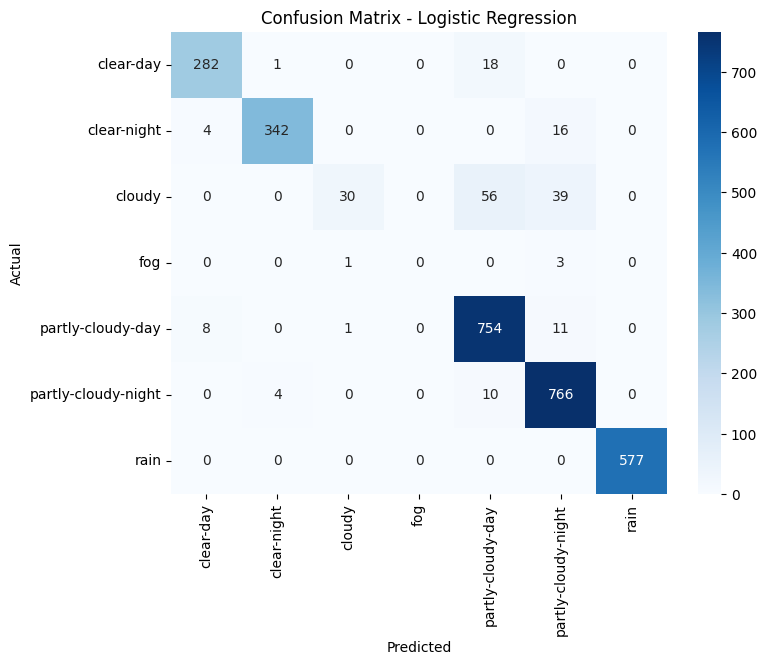

In [240]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [241]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.9s remaining:    6.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.0s finished


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [242]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [243]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9968
clear-night : 0.9982
cloudy   : 0.9674
fog      : 0.9955
partly-cloudy-day : 0.9930
partly-cloudy-night : 0.9930
rain     : 1.0000
Micro-avg : 0.9950


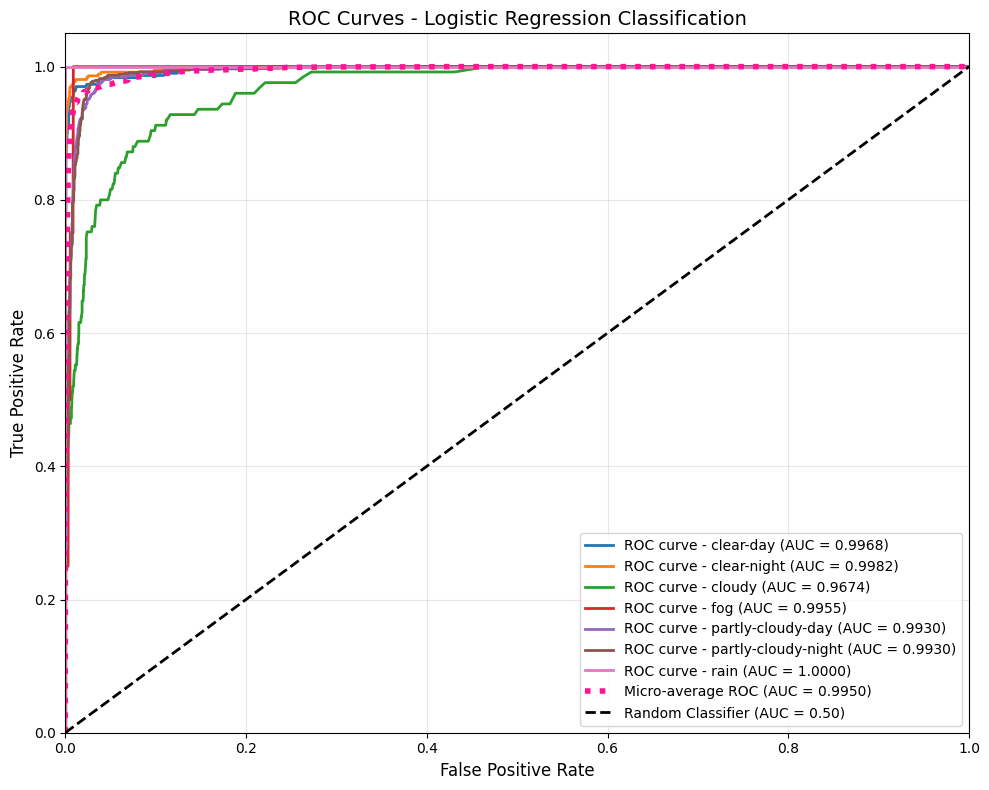

In [244]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [245]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9943
One-vs-One (Weighted)  : 0.9888
Micro-average          : 0.9950


In [246]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.932603 → 0.941156
   F1-Score: 0.920456 → 0.931680
   AUC (micro-avg): 0.994633 → 0.994980
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


### Robust Scaler

In [247]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [248]:
X_train

array([[ 0.00000000e+00, -9.16666667e-01,  0.00000000e+00, ...,
        -5.05562827e-02,  0.00000000e+00,  9.07710558e+00],
       [ 0.00000000e+00,  5.83333333e-01,  0.00000000e+00, ...,
         3.25752618e-01,  0.00000000e+00,  0.00000000e+00],
       [ 4.00000000e-01,  6.66666667e-01,  0.00000000e+00, ...,
         2.12696335e-03,  0.00000000e+00,  1.22419929e+00],
       ...,
       [ 2.00000000e-01, -7.50000000e-01,  0.00000000e+00, ...,
         6.20418848e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -8.33333333e-02,  0.00000000e+00, ...,
         5.83442408e-01,  1.94805195e+00,  9.18149466e+00],
       [ 2.00000000e-01, -2.50000000e-01,  0.00000000e+00, ...,
         7.77977749e-01,  1.01948052e+00,  0.00000000e+00]])

In [249]:
X_test

array([[ 0.8       , -0.91666667,  0.        , ..., -0.78943063,
         0.        ,  0.        ],
       [-0.2       , -0.75      ,  0.        , ..., -0.03730366,
         0.        , -0.42704626],
       [ 0.4       ,  0.25      ,  1.        , ...,  0.5430301 ,
         1.06060606,  8.26571767],
       ...,
       [ 0.4       , -0.75      ,  0.        , ...,  0.09096859,
         0.        ,  0.        ],
       [ 1.        ,  0.16666667,  1.        , ..., -0.36731021,
         1.51515152,  0.        ],
       [ 0.4       , -0.08333333,  0.        , ...,  0.79384817,
         0.25757576,  0.        ]])

#### Default Parameters

In [250]:
training_model = KNeighborsClassifier()
training_model

KNeighborsClassifier()

In [251]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 12.9 ms, sys: 0 ns, total: 12.9 ms
Wall time: 12.4 ms


KNeighborsClassifier()

In [252]:
y_pred = training_model.predict(X_test)
y_pred

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], dtype=object)

In [253]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [254]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [255]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.8998
Precision: 0.8892
Recall:    0.8998
F1-Score:  0.8922


In [256]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.91      0.90      0.91       301
        clear-night       0.96      0.88      0.92       362
             cloudy       0.38      0.18      0.24       125
                fog       0.50      0.25      0.33         4
  partly-cloudy-day       0.86      0.92      0.89       774
partly-cloudy-night       0.87      0.93      0.90       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.90      2923
          macro avg       0.78      0.72      0.74      2923
       weighted avg       0.89      0.90      0.89      2923



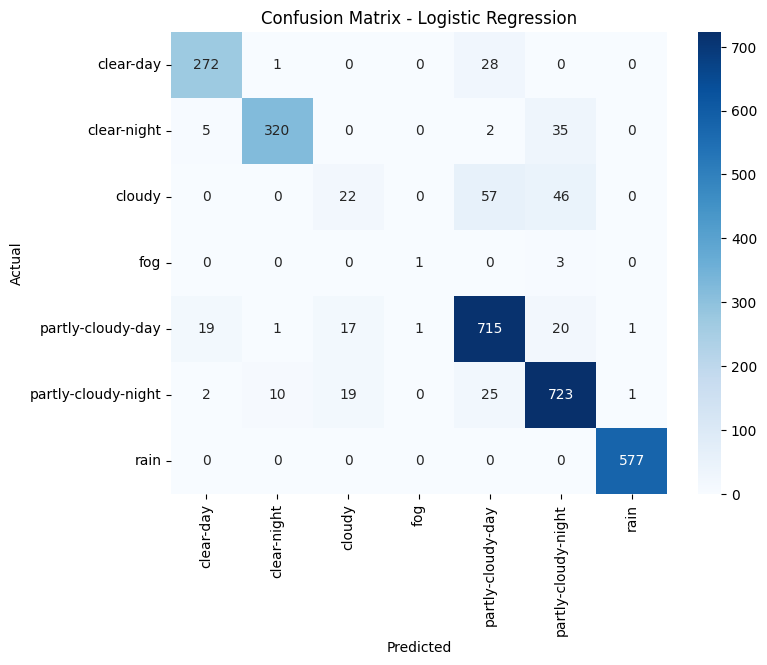

In [257]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [258]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [259]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [260]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9889
clear-night : 0.9910
cloudy   : 0.8140
fog      : 0.7482
partly-cloudy-day : 0.9805
partly-cloudy-night : 0.9802
rain     : 1.0000
Micro-avg : 0.9839


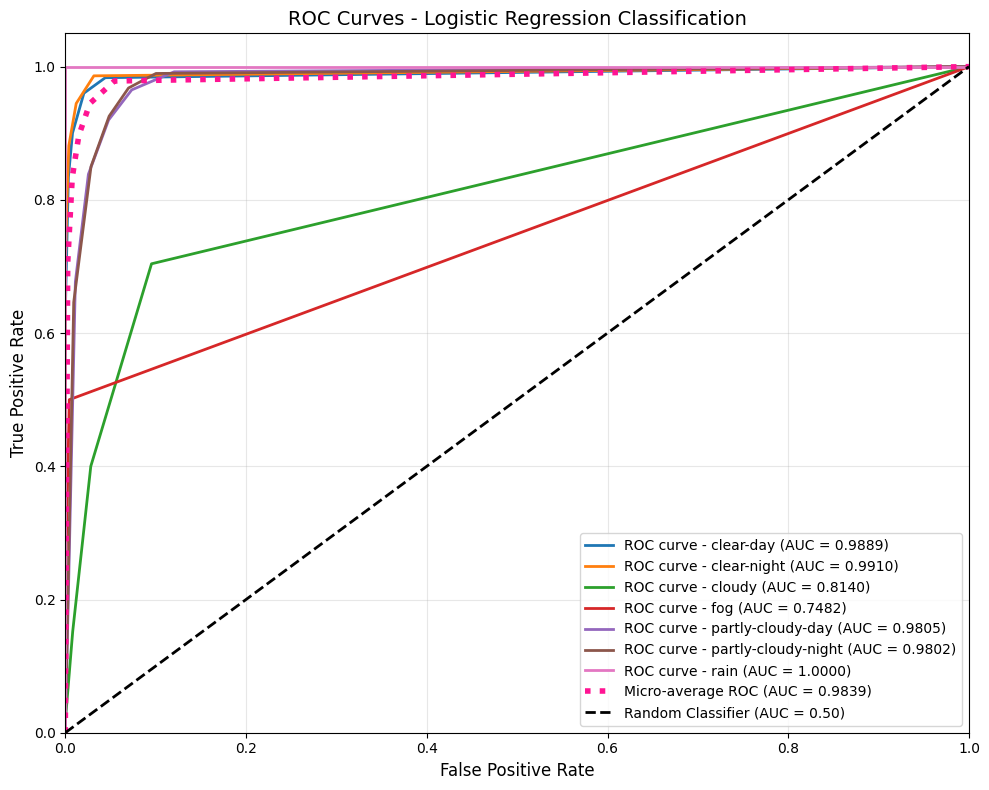

In [261]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [262]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9790
One-vs-One (Weighted)  : 0.9426
Micro-average          : 0.9839


In [263]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.875813 → 0.899761
   F1-Score: 0.868196 → 0.892155
   AUC (micro-avg): 0.978048 → 0.983923
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [264]:
grid_search = RandomizedSearchCV(
    KNeighborsClassifier(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [265]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
CPU times: user 12.1 s, sys: 4.51 s, total: 16.6 s
Wall time: 1h 12s


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [266]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 7, 'metric': 'manhattan', 'leaf_size': 20, 'algorithm': 'ball_tree'}
Best Cross-Validation Score: 0.9012272975940867


In [267]:
y_pred_grid = best_grid_model.predict(X_test)

In [268]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [269]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9162
Precision: 0.9078
Recall:    0.9162
F1-Score:  0.9073


In [270]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.90      0.91      0.90       301
        clear-night       0.97      0.91      0.94       362
             cloudy       0.61      0.22      0.32       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.89      0.93      0.91       774
partly-cloudy-night       0.89      0.96      0.93       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.92      2923
          macro avg       0.75      0.70      0.71      2923
       weighted avg       0.91      0.92      0.91      2923



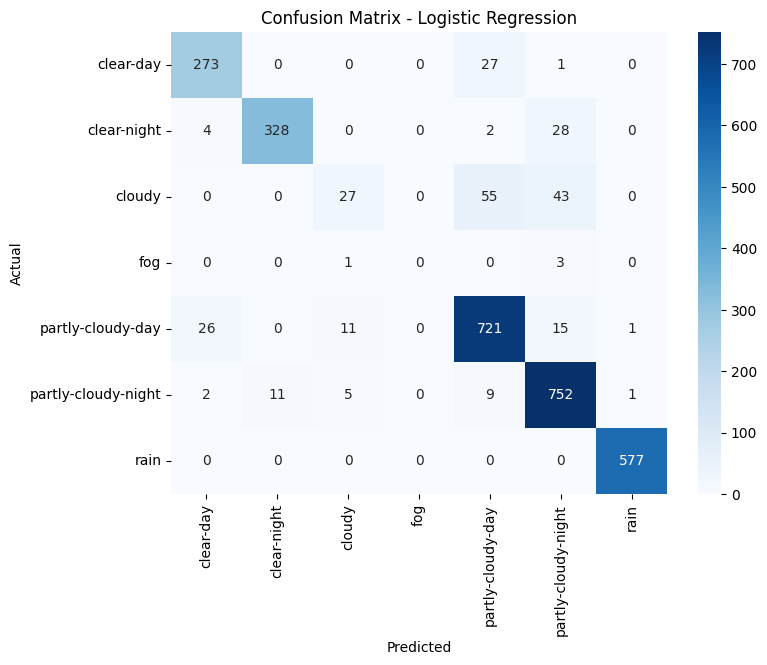

In [271]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [272]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [273]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [274]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9933
clear-night : 0.9953
cloudy   : 0.8740
fog      : 0.7479
partly-cloudy-day : 0.9846
partly-cloudy-night : 0.9865
rain     : 1.0000
Micro-avg : 0.9892


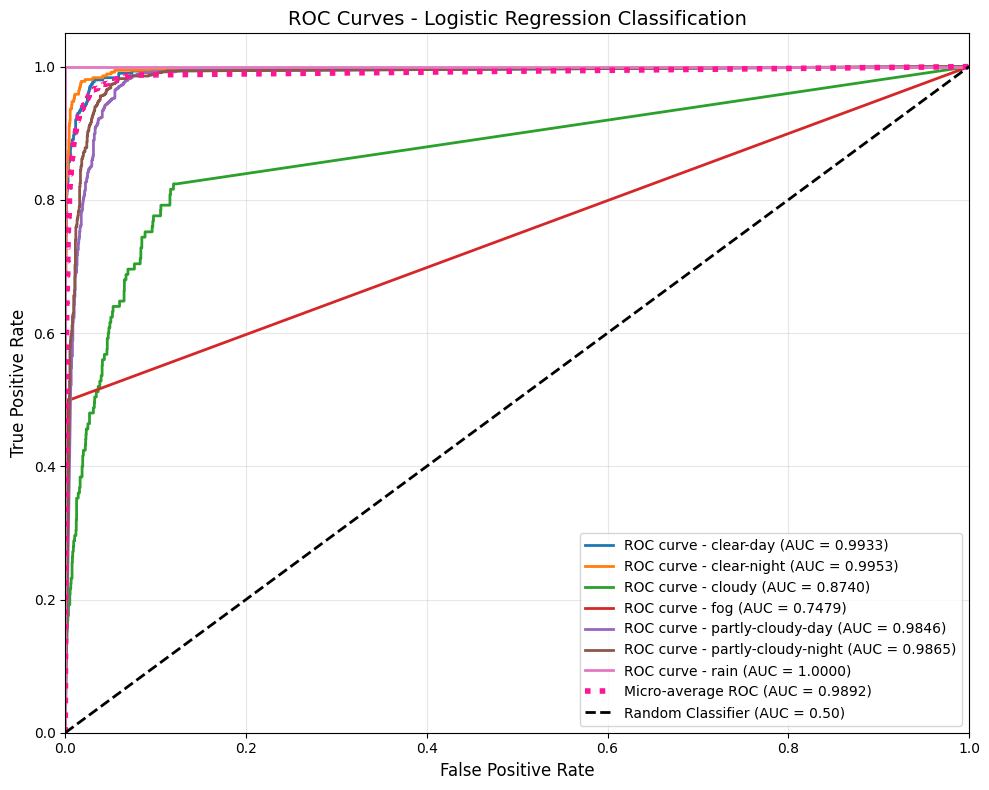

In [275]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [276]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9853
One-vs-One (Weighted)  : 0.9526
Micro-average          : 0.9892


In [277]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.900103 → 0.916182
   F1-Score: 0.887822 → 0.907286
   AUC (micro-avg): 0.987808 → 0.989194
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [278]:
base_model = KNeighborsClassifier()
base_model

KNeighborsClassifier()

In [279]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [280]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s


CPU times: user 141 ms, sys: 438 ms, total: 579 ms
Wall time: 1.12 s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.0s finished


BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [281]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.9s remaining:    6.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.0s finished


In [282]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [283]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9234
Precision: 0.9254
Recall:    0.9234
F1-Score:  0.9102


In [284]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.95      0.92      0.93       301
        clear-night       0.98      0.90      0.94       362
             cloudy       0.94      0.14      0.24       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.88      0.96      0.92       774
partly-cloudy-night       0.89      0.97      0.93       780
               rain       0.99      1.00      1.00       577

           accuracy                           0.92      2923
          macro avg       0.80      0.70      0.71      2923
       weighted avg       0.93      0.92      0.91      2923



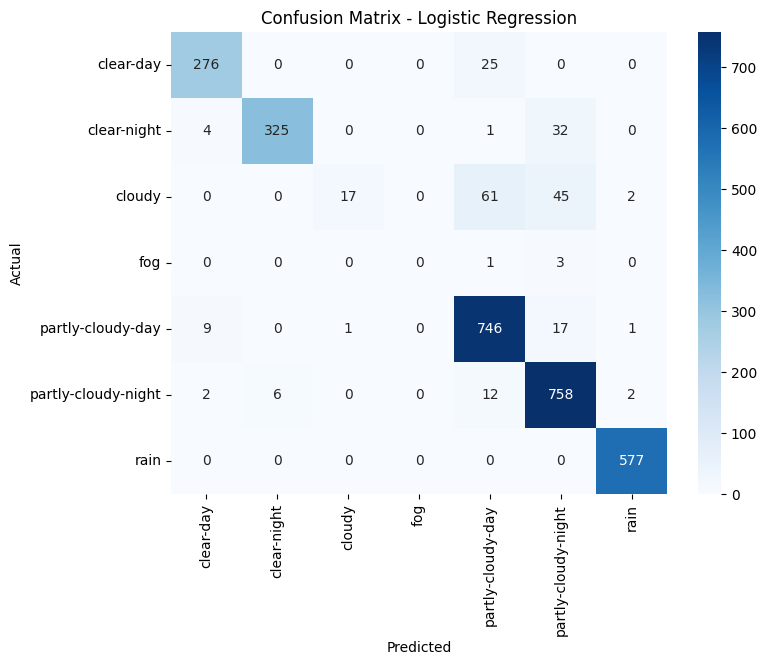

In [285]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [286]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.3s remaining:    7.3s


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.7s finished


In [287]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [288]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9960
clear-night : 0.9977
cloudy   : 0.9541
fog      : 0.9949
partly-cloudy-day : 0.9894
partly-cloudy-night : 0.9891
rain     : 1.0000
Micro-avg : 0.9938


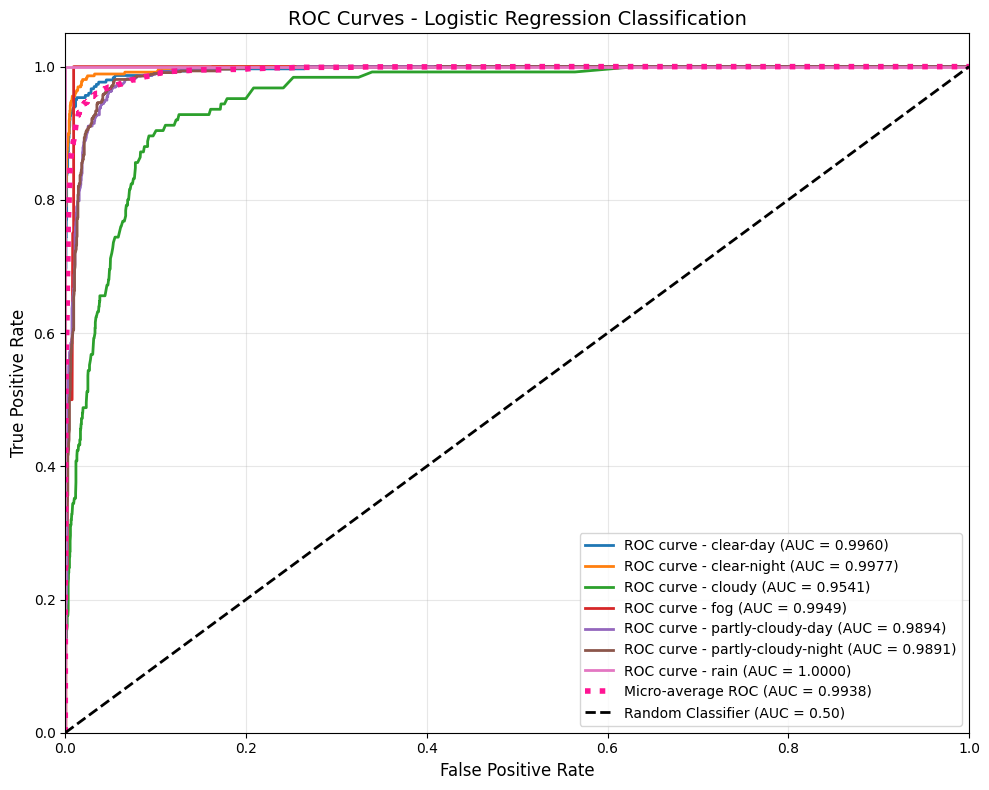

In [289]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [290]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9916
One-vs-One (Weighted)  : 0.9840
Micro-average          : 0.9938


In [291]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.921314 → 0.923366
   F1-Score: 0.906961 → 0.910197
   AUC (micro-avg): 0.993999 → 0.993805
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


# All Performance

In [292]:
show_model_history('classification', model_name=model_name_for_saving, target_column=target_name_for_saving)


📊 CLASSIFICATION Model Performance History
      Model         Scaler Target  Features Accuracy Precision   Recall F1-Score
KNN Bagging   MinMaxScaler   Icon        23 0.953130  0.953112 0.953130 0.946395
   KNN Grid   MinMaxScaler   Icon        23 0.949025  0.946356 0.949025 0.943972
        KNN   MinMaxScaler   Icon        23 0.944235  0.939174 0.944235 0.938218
KNN Bagging StandardScaler   Icon        23 0.941156  0.941377 0.941156 0.931680
   KNN Grid StandardScaler   Icon        23 0.930209  0.924678 0.930209 0.925913
        KNN StandardScaler   Icon        23 0.926445  0.919534 0.926445 0.919574
KNN Bagging   RobustScaler   Icon        23 0.923366  0.925433 0.923366 0.910197
   KNN Grid   RobustScaler   Icon        23 0.916182  0.907828 0.916182 0.907286
        KNN   RobustScaler   Icon        23 0.899761  0.889211 0.899761 0.892155

📈 Total models shown: 9
🏆 Best F1-Score: 0.946395 (KNN Bagging + MinMaxScaler for Icon)


# <center><font size="50" color="red">Thank You</font></center>